# CA YOUTH PAROLE

In [1]:
"""
STATE: CA
POLICY: Youth Parole for Life-With-Parole Clients
VERSION: V3
DATA SOURCE: CDCR
DATA QUALITY: good
HIGHEST PRIORITY MISSING DATA: N/A
REFERENCE_DATE: October 2022
TIME_STEP: Month
ADDITIONAL NOTES: Initial policy scoping doc https://docs.google.com/document/d/1mj6Fmm3aCmx08PqhNShV6Rb8MCRuHQ2D56BmxeJKxKg/edit?usp=sharing
"""

import logging
import pandas as pd
import numpy as np
import pdb
import matplotlib as plt
from IPython.display import display
import itertools


%run /Users/jazz/Recidiviz/recidiviz-research/utils/research_utils.py

pd.options.display.max_colwidth = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_seq_items", None)
pd.set_option("display.width", None)

In [2]:
import sys

sys.path.insert(1, "/Users/jazz/Recidiviz/pulse-data")

In [3]:
from recidiviz.calculator.modeling.population_projection.super_simulation.time_converter import (
    TimeConverter,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import (
    upload_spark_model_inputs,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_preprocessing_utils import (
    convert_dates,
)
from recidiviz.utils.yaml_dict import YAMLDict

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

# Data setup

In [4]:
day_of_data = pd.to_datetime("2022-10-31")
ca_full = pd.read_csv("C006035_2022_10_31.csv")
ca = ca_full

ca["time_served_months"] = ca["Time Served (Months)"]
ca["time_served_years"] = ca.time_served_months / 12

# Calculate prison start date using Time Served field relative to snapshot date
ca["start_date_calc"] = day_of_data - pd.to_timedelta(
    ca.time_served_months * 30.4167, "d"
)

In [5]:
# Sentence types plot

# ca["start_year"] = ca.start_date_calc.dt.year
# sentypes = (
#     ca.groupby(["start_year", "SenType"])[["ID"]]
#     .count()
#     .reset_index()
#     .pivot(index="start_year", columns="SenType", values="ID")
# )
# # sentypes.tail(7).to_csv('sentypes_CA.csv')
# sentypes.loc[1960:].plot()

# plt.title("Clients by Admission Date and Sentence Type for Current Prison Population");

# ca = ca.drop(labels=["start_year"], axis=1)

## Eligible population

In [6]:
ca_total_prison_pop = ca.shape[0]

In [7]:
# proportion of clients in prison under 26
# ca[ca["Age"] < 26].drop_duplicates(subset='ID').shape[0] / ca.drop_duplicates(subset='ID').shape[0]

In [8]:
# Limit eligible group
ca = ca.loc[ca["Offense Age"] < 26]

In [9]:
ca.shape[0]

36768

In [10]:
# proportion of youth offenders in prison
ca.shape[0] / ca_total_prison_pop

0.38395188070424596

In [11]:
ca = ca.loc[ca.SenType == "Life with Parole"]
# ca = ca.loc[~ca["Offense Group"].str.contains("Murder 1st")]

In [12]:
ca.drop_duplicates(subset="ID").shape

(12207, 19)

In [13]:
ca.head()

,ID,SenType,Minimum,Maximum,ReleaseType,Offense Group,Race,Ethnicity,Gender,Age,Offense Age,Time Served (Months),Revocation (Y/N),Housing Program,Disability Placement Program,Time Period,time_served_months,time_served_years,start_date_calc
5,254,Life with Parole,54Y 4M,Life w/ Parole,MEPD,Other Assault/Battery,White,White,Female,55,23,342.2,No,General Population,NaN,1990-06-06 - 9999-12-31,342.2,28.516667,1994-05-02 09:43:34.464000000
36,6302,Life with Parole,7Y 0M,Life w/ Parole,MEPD,Murder 1st,White,White,Female,73,19,630.9,No,General Population,NaN,1000-01-01 - 1978-11-07,630.9,52.575000,1970-04-17 02:29:43.008000000
84,14552,Life with Parole,12Y 0M,Life w/ Parole,MEPD,Other Assault/Battery,Black,Black,Female,50,18,371.4,No,General Population,NaN,1990-01-01 - 9999-12-31,371.4,30.950000,1991-11-26 05:42:10.368000001
90,15698,Life with Parole,58Y 0M,Life w/ Parole,MEPD,Murder 1st,Mexican,Mexican,Female,49,25,278.2,No,General Population,NaN,1979-01-01 - 9999-12-31,278.2,23.183333,1999-08-31 01:46:38.784000000
188,26038,Life with Parole,80Y 0M,Life w/ Parole,MEPD,Murder 1st,Hispanic,Hispanic,Female,35,25,119.9,No,General Population,NaN,1979-01-01 - 9999-12-31,119.9,9.991667,2012-11-05 00:54:14.688000000


In [169]:
ca[["minimum_years", "minimum_months"]] = ca.Minimum.str.extract(
    r"(\d*)Y\s(\d*)M", expand=True
)
ca["minimum_sentence_years"] = ca.minimum_years.astype(float) + (
    ca.minimum_months.astype(float) / 12
)
ca = ca.drop(labels=["minimum_years", "minimum_months"], axis=1)

In [170]:
policy_parole_years = 15
policy_date = pd.to_datetime("2023-07")

In [171]:
def get_parole_eligibility_years(x):
    if x.minimum_sentence_years >= 25:
        return 25
    if x.minimum_sentence_years >= 20:
        return 20
    else:
        return x.minimum_sentence_years

In [172]:
ca["parole_eligibility_years"] = ca.apply(
    lambda x: get_parole_eligibility_years(x), axis=1
)

# subtract 1 year to model hearings at beginning of the year
ca["parole_eligibility_date_control"] = ca.start_date_calc + pd.to_timedelta(
    (ca.parole_eligibility_years - 1) * 365.25, "d"
)
ca["parole_eligibility_date_policy"] = ca.start_date_calc + pd.to_timedelta(
    (policy_parole_years - 1) * 365.25, "d"
)

In [173]:
# parole_types = (
#     (
#         ca.groupby(["start_year", ca.parole_eligibility_years>=25])[["ID"]]
#         .count()
#         .reset_index()
#         .pivot(index="start_year", columns="parole_eligibility_years", values="ID")
#     ).loc[1980:]
#         .plot()
# )
# plt.title("Clients by Admission Date And Current Number of Years to Parole Eligibility");

In [174]:
# Further limit eligible group to those with a new parole date

# Only those who have sentences with minimums > 15 years (otherwise no effect)
ca = ca.loc[ca.minimum_sentence_years > policy_parole_years]

# Only those who won't already be eligible for parole under current parole guidelines
ca = ca.loc[ca.parole_eligibility_date_control >= policy_date]

In [175]:
def policy_date_plus_n_years(n):
    return policy_date + pd.to_timedelta(n * 365.25, "d")

In [176]:
ca["immediately_eligible"] = ca.parole_eligibility_date_policy <= policy_date
ca[
    "eligible_within_two_years"
] = ca.parole_eligibility_date_policy <= policy_date_plus_n_years(2)

In [177]:
ca["subset"] = "eligible_after_two_years"
ca["subset"] = ca.subset.mask(ca.eligible_within_two_years, "eligible_within_two_years")
ca["subset"] = ca.subset.mask(ca.immediately_eligible, "immediately_eligible")

In [178]:
ca.head()

,ID,SenType,Minimum,Maximum,ReleaseType,Offense Group,Race,Ethnicity,Gender,Age,Offense Age,Time Served (Months),Revocation (Y/N),Housing Program,Disability Placement Program,Time Period,time_served_months,time_served_years,start_date_calc,minimum_sentence_years,parole_eligibility_years,parole_eligibility_date_control,parole_eligibility_date_policy,immediately_eligible,eligible_within_two_years,subset
90,15698,Life with Parole,58Y 0M,Life w/ Parole,MEPD,Murder 1st,Mexican,Mexican,Female,49,25,278.2,No,General Population,NaN,1979-01-01 - 9999-12-31,278.2,23.183333,1999-08-31 01:46:38.784,58.000000,25.0,2023-08-31 01:46:38.784,2013-08-30 13:46:38.784,True,True,immediately_eligible
188,26038,Life with Parole,80Y 0M,Life w/ Parole,MEPD,Murder 1st,Hispanic,Hispanic,Female,35,25,119.9,No,General Population,NaN,1979-01-01 - 9999-12-31,119.9,9.991667,2012-11-05 00:54:14.688,80.000000,25.0,2036-11-05 00:54:14.688,2026-11-05 12:54:14.688,False,False,eligible_after_two_years
367,65851,Life with Parole,85Y 0M,Life w/ Parole,MEPD,Other Assault/Battery,Black,Black,Female,44,22,261.1,No,General Population,NaN,1994-03-07 - 9999-12-31,261.1,21.758333,2001-02-01 04:47:28.032,85.000000,25.0,2025-02-01 04:47:28.032,2015-02-01 16:47:28.032,True,True,immediately_eligible
458,74877,Life with Parole,29Y 8M,Life w/ Parole,MEPD,Kidnapping,Black,Black,Female,42,19,275.3,No,General Population,NaN,1993-10-01 - 9999-12-31,275.3,22.941667,1999-11-27 06:46:47.136,29.666667,25.0,2023-11-27 06:46:47.136,2013-11-26 18:46:47.136,True,True,immediately_eligible
476,75863,Life with Parole,25Y 0M,Life w/ Parole,MEPD,Other Assault/Battery,Mexican,Mexican,Female,46,23,273.6,No,General Population,NaN,1997-01-01 - 9999-12-31,273.6,22.800000,2000-01-17 23:46:52.032,25.000000,25.0,2024-01-17 23:46:52.032,2014-01-17 11:46:52.032,True,True,immediately_eligible


In [215]:
ca.subset.value_counts()

immediately_eligible         4068
eligible_after_two_years     2389
eligible_within_two_years     779
Name: subset, dtype: int64

# Sessions

In [180]:
starting_population = len(ca)
starting_population

7236

### adjust hearing dates within first 2 years

In [181]:
first_hearing_adj = ca[ca.eligible_within_two_years][
    ["ID", "parole_eligibility_date_policy"]
].copy()
first_hearing_adj = first_hearing_adj.sort_values(
    by="parole_eligibility_date_policy"
).reset_index(drop=True)
first_hearing_adj["two_year_hearing_spread"] = pd.date_range(
    policy_date, policy_date_plus_n_years(2), len(first_hearing_adj)
)

In [182]:
cas_adj = pd.merge(
    ca, first_hearing_adj, on=["ID", "parole_eligibility_date_policy"], how="left"
)
cas_adj.eligible_within_two_years.fillna(False, inplace=True)

In [183]:
cas_adj[
    "parole_eligibility_date_policy_adjusted"
] = cas_adj.two_year_hearing_spread.combine_first(
    cas_adj.parole_eligibility_date_policy
)

### add multiple hearing dates

In [184]:
hearing_grant_rate = 0.17
pflows = pd.DataFrame(
    columns=[
        "hearing_number",
        "relative_years",
        "second_hearing_proportion",
        "grant_rate",
    ]
).set_index("hearing_number")

pflows.loc[1] = [0, None, hearing_grant_rate]
pflows.loc[2] = [3, 0.612, hearing_grant_rate]
pflows.loc[3] = [5, 0.29, hearing_grant_rate]
pflows.loc[4] = [7, 0.079, hearing_grant_rate]
pflows.loc[5] = [10, 0.016, hearing_grant_rate]
pflows.loc[6] = [15, 0.002, hearing_grant_rate]

pflows["time_offset"] = pd.to_timedelta(pflows.relative_years * 365.25, "d")

pflows["remaining_hearing_proportion"] = (
    1 - hearing_grant_rate
) * pflows.second_hearing_proportion
pflows.loc[1, "remaining_hearing_proportion"] = 1

pflows["percent_outflow"] = pflows.remaining_hearing_proportion * hearing_grant_rate
pflows.loc[1, "percent_outflow"] = hearing_grant_rate

pflows["hearing_label"] = (
    "2nd Hearing, after " + pflows.relative_years.astype(int).astype(str) + " yrs"
)
pflows.loc[1, "hearing_label"] = "1st Hearing"
pflows.reset_index(inplace=True)

In [185]:
pflows

,hearing_number,relative_years,second_hearing_proportion,grant_rate,time_offset,remaining_hearing_proportion,percent_outflow,hearing_label
0,1,0.0,NaN,0.17,0 days 00:00:00,1.00000,0.170000,1st Hearing
1,2,3.0,0.612,0.17,1095 days 18:00:00,0.50796,0.086353,"2nd Hearing, after 3 yrs"
2,3,5.0,0.290,0.17,1826 days 06:00:00,0.24070,0.040919,"2nd Hearing, after 5 yrs"
3,4,7.0,0.079,0.17,2556 days 18:00:00,0.06557,0.011147,"2nd Hearing, after 7 yrs"
4,5,10.0,0.016,0.17,3652 days 12:00:00,0.01328,0.002258,"2nd Hearing, after 10 yrs"
5,6,15.0,0.002,0.17,5478 days 18:00:00,0.00166,0.000282,"2nd Hearing, after 15 yrs"


In [216]:
pflows[pflows.hearing_label.str.contains("2")].remaining_hearing_proportion.sum()

0.8291699999999999

In [186]:
cas = pd.merge(
    cas_adj,
    pflows[
        [
            "hearing_label",
            "percent_outflow",
            "time_offset",
            "remaining_hearing_proportion",
        ]
    ],
    how="cross",
)

### calculate final hearing/release dates

In [187]:
cas["hearing_date_control"] = cas.parole_eligibility_date_control + cas.time_offset
cas["hearing_date_policy"] = (
    cas.parole_eligibility_date_policy_adjusted + cas.time_offset
)

In [188]:
cas.head()

,ID,SenType,Minimum,Maximum,ReleaseType,Offense Group,Race,Ethnicity,Gender,Age,Offense Age,Time Served (Months),Revocation (Y/N),Housing Program,Disability Placement Program,Time Period,time_served_months,time_served_years,start_date_calc,minimum_sentence_years,parole_eligibility_years,parole_eligibility_date_control,parole_eligibility_date_policy,immediately_eligible,eligible_within_two_years,subset,two_year_hearing_spread,parole_eligibility_date_policy_adjusted,hearing_label,percent_outflow,time_offset,remaining_hearing_proportion,hearing_date_control,hearing_date_policy
0,15698,Life with Parole,58Y 0M,Life w/ Parole,MEPD,Murder 1st,Mexican,Mexican,Female,49,25,278.2,No,General Population,NaN,1979-01-01 - 9999-12-31,278.2,23.183333,1999-08-31 01:46:38.784,58.0,25.0,2023-08-31 01:46:38.784,2013-08-30 13:46:38.784,True,True,immediately_eligible,2023-07-08 12:53:29.244737928,2023-07-08 12:53:29.244737928,1st Hearing,0.170000,0 days 00:00:00,1.00000,2023-08-31 01:46:38.784,2023-07-08 12:53:29.244737928
1,15698,Life with Parole,58Y 0M,Life w/ Parole,MEPD,Murder 1st,Mexican,Mexican,Female,49,25,278.2,No,General Population,NaN,1979-01-01 - 9999-12-31,278.2,23.183333,1999-08-31 01:46:38.784,58.0,25.0,2023-08-31 01:46:38.784,2013-08-30 13:46:38.784,True,True,immediately_eligible,2023-07-08 12:53:29.244737928,2023-07-08 12:53:29.244737928,"2nd Hearing, after 3 yrs",0.086353,1095 days 18:00:00,0.50796,2026-08-30 19:46:38.784,2026-07-08 06:53:29.244737928
2,15698,Life with Parole,58Y 0M,Life w/ Parole,MEPD,Murder 1st,Mexican,Mexican,Female,49,25,278.2,No,General Population,NaN,1979-01-01 - 9999-12-31,278.2,23.183333,1999-08-31 01:46:38.784,58.0,25.0,2023-08-31 01:46:38.784,2013-08-30 13:46:38.784,True,True,immediately_eligible,2023-07-08 12:53:29.244737928,2023-07-08 12:53:29.244737928,"2nd Hearing, after 5 yrs",0.040919,1826 days 06:00:00,0.24070,2028-08-30 07:46:38.784,2028-07-07 18:53:29.244737928
3,15698,Life with Parole,58Y 0M,Life w/ Parole,MEPD,Murder 1st,Mexican,Mexican,Female,49,25,278.2,No,General Population,NaN,1979-01-01 - 9999-12-31,278.2,23.183333,1999-08-31 01:46:38.784,58.0,25.0,2023-08-31 01:46:38.784,2013-08-30 13:46:38.784,True,True,immediately_eligible,2023-07-08 12:53:29.244737928,2023-07-08 12:53:29.244737928,"2nd Hearing, after 7 yrs",0.011147,2556 days 18:00:00,0.06557,2030-08-30 19:46:38.784,2030-07-08 06:53:29.244737928
4,15698,Life with Parole,58Y 0M,Life w/ Parole,MEPD,Murder 1st,Mexican,Mexican,Female,49,25,278.2,No,General Population,NaN,1979-01-01 - 9999-12-31,278.2,23.183333,1999-08-31 01:46:38.784,58.0,25.0,2023-08-31 01:46:38.784,2013-08-30 13:46:38.784,True,True,immediately_eligible,2023-07-08 12:53:29.244737928,2023-07-08 12:53:29.244737928,"2nd Hearing, after 10 yrs",0.002258,3652 days 12:00:00,0.01328,2033-08-30 13:46:38.784,2033-07-08 00:53:29.244737928


In [189]:
release_to_parole_delay = pd.to_timedelta(150, "d")
cas["release_date_control"] = cas.hearing_date_control + release_to_parole_delay
cas["release_date_policy"] = cas.hearing_date_policy + release_to_parole_delay

In [190]:
cas["release_month_control"] = cas.release_date_control.dt.to_period(
    "M"
).dt.to_timestamp()
cas["release_month_policy"] = cas.release_date_policy.dt.to_period(
    "M"
).dt.to_timestamp()

## extra stats

In [208]:
cstats = cas.copy()

In [209]:
cstats["time_to_control_hearing"] = (cstats.hearing_date_control - policy_date).dt.days

In [210]:
cstats[(cstats.hearing_label.str.contains("1st"))].time_to_control_hearing.describe()

count    7236.000000
mean     3290.072692
std      1917.564165
min         0.000000
25%      1763.250000
50%      3093.000000
75%      4733.000000
max      8477.000000
Name: time_to_control_hearing, dtype: float64

In [ ]:
cstats[
    (cstats.hearing_label.str.contains("1st"))
    & (cstats.hearing_date_control < policy_date_plus_n_years(10))
].shape

In [ ]:
cstats[
    (cstats.hearing_label.str.contains("1st"))
    & (cstats.hearing_date_control < policy_date_plus_n_years(10))
].shape

In [213]:
cstats[
    (cstats.hearing_label.str.contains("1st"))
    & (cstats.hearing_date_policy < policy_date_plus_n_years(10))
].shape

(7092, 40)

In [196]:
cas["release_delta"] = cas.release_date_control - cas.release_date_policy
released_within_five_years = cas[cas.release_date_policy < policy_date_plus_n_years(10)]

In [197]:
change_in_release_dates = released_within_five_years["release_delta"].dt.days
weights = released_within_five_years["percent_outflow"]
delta = ((change_in_release_dates * weights).sum() / weights.sum() / 365.25).round(2)
print(f"Average change in prison stay for 1st 5 years: {delta} years")

Average change in prison stay for 1st 5 years: 6.2 years


In [198]:
average_age = released_within_five_years["Age"]
weights = released_within_five_years["percent_outflow"]
age = ((average_age * weights).sum() / weights.sum()).round(2)
print(f"Average age for affected clients for 1st 5 years: {age} years")

Average age for affected clients for 1st 5 years: 35.9 years


In [194]:
from statsmodels.stats.weightstats import DescrStatsW

wdf = DescrStatsW(average_age, weights=weights, ddof=1)

print(wdf.mean)
print(wdf.std)
print(wdf.quantile([0.25, 0.50, 0.75]))
print(wdf.quantile([0.01, 0.50, 0.75]))

37.38163267670117
5.048825294452448
p
0.25    34
0.50    37
0.75    41
dtype: int64
p
0.01    27
0.50    37
0.75    41
dtype: int64


## Calculate results

In [195]:
outflowed_control = (
    cas.groupby("release_month_control")
    .percent_outflow.sum()
    .reindex(
        pd.date_range(
            start="2023-01-01", end=cas.release_month_control.max(), freq="MS"
        )
    )
    .fillna(0)
    .cumsum()
)
pop_control = starting_population - outflowed_control

In [37]:
outflowed_policy = (
    cas.groupby("release_month_policy")
    .percent_outflow.sum()
    .reindex(
        pd.date_range(start="2023-01-01", end=cas.release_month_policy.max(), freq="MS")
    )
    .fillna(0)
    .cumsum()
)
pop_policy = starting_population - outflowed_policy

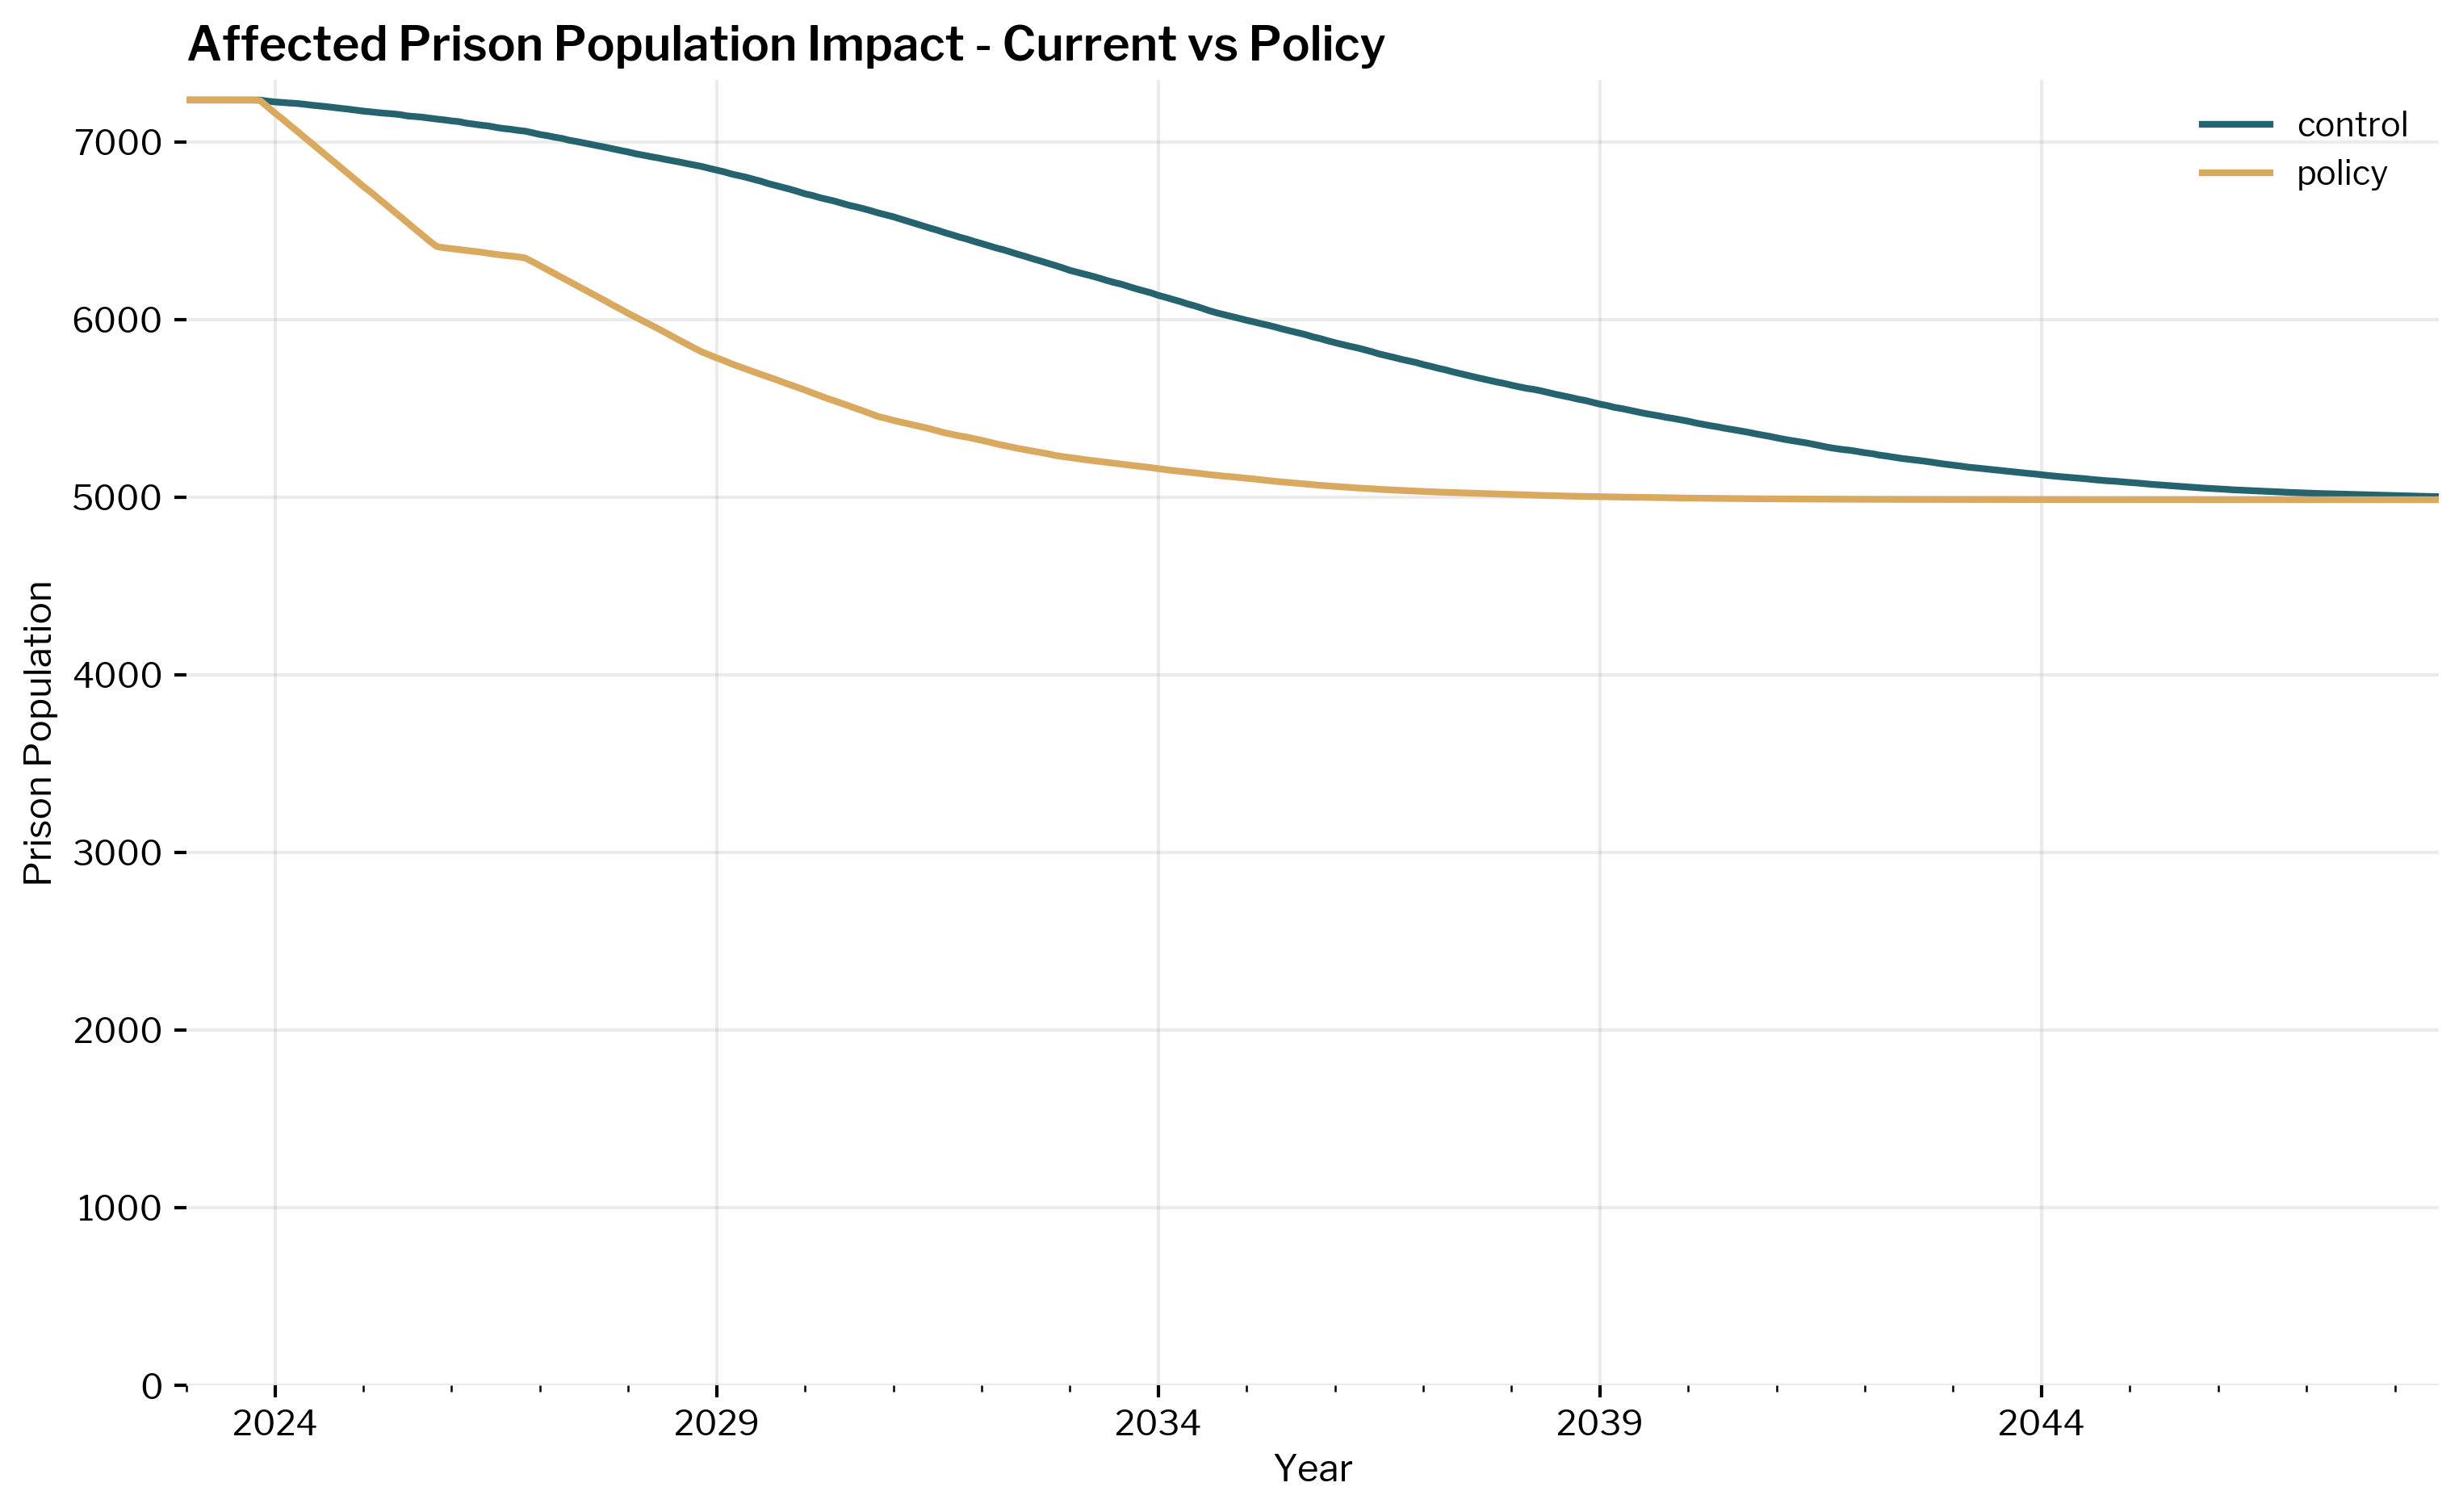

In [38]:
pop_policy = pop_policy.rename("policy").round(2)
pop_control = pop_control.rename("control").round(2)
totals = pd.concat([pop_control, pop_policy], axis=1)
totals.loc["2023-01-01":"2048-07-01"].plot()
plt.ylim(0)
plt.title("Affected Prison Population Impact - Current vs Policy")
plt.ylabel("Prison Population")
plt.xlabel("Year");

In [39]:
totals["difference"] = totals.control - totals.policy

In [40]:
totals["life_years_out_of_prison"] = (totals.difference.cumsum() / 12).round(2)

In [41]:
cost_of_prison = 29000
cost_of_parole = 10182
diff_cost = cost_of_prison - cost_of_parole

In [42]:
totals["cost_savings_mil"] = totals.life_years_out_of_prison * diff_cost / 1000000

In [43]:
totals.loc[pd.date_range(start="2023-01-01", end="2033-01-01", freq="YS")]

,control,policy,difference,life_years_out_of_prison,cost_savings_mil
2023-01-01,7236.00,7236.00,0.00,0.00,0.000000
2024-01-01,7225.46,7162.56,62.90,8.20,0.154308
2025-01-01,7173.61,6749.80,423.81,268.05,5.044165
2026-01-01,7118.53,6399.09,719.44,876.96,16.502633
2027-01-01,7042.12,6303.39,738.73,1595.09,30.016404
2028-01-01,6943.53,6034.57,908.96,2426.50,45.661877
2029-01-01,6841.61,5784.39,1057.22,3420.45,64.366028
2030-01-01,6708.21,5603.69,1104.52,4507.31,84.818560
2031-01-01,6578.85,5432.71,1146.14,5639.22,106.118842
2032-01-01,6428.07,5320.19,1107.88,6765.37,127.310733


In [44]:
totals.loc[pd.date_range(start="2023-01-01", end="2035-01-01", freq="AS-JUL")]

,control,policy,difference,life_years_out_of_prison,cost_savings_mil
2023-07-01,7236.00,7236.00,0.00,0.00,0.000000
2024-07-01,7202.85,6957.37,245.48,93.06,1.751203
2025-07-01,7146.41,6545.80,600.61,531.60,10.003649
2026-07-01,7082.32,6367.30,715.02,1235.28,23.245499
2027-07-01,6993.83,6169.08,824.75,1989.80,37.444056
2028-07-01,6894.35,5905.01,989.34,2903.55,54.639004
2029-07-01,6779.19,5691.68,1087.51,3958.46,74.490300
2030-07-01,6643.48,5514.18,1129.30,5067.91,95.367930
2031-07-01,6503.19,5373.48,1129.71,6206.81,116.799751
2032-07-01,6354.96,5266.94,1088.02,7314.11,137.636922


2024-07-01     -93.06
2025-07-01    -531.60
2026-07-01   -1235.28
2027-07-01   -1989.80
2028-07-01   -2903.55
Freq: 12MS, Name: life_years_out_of_prison, dtype: float64

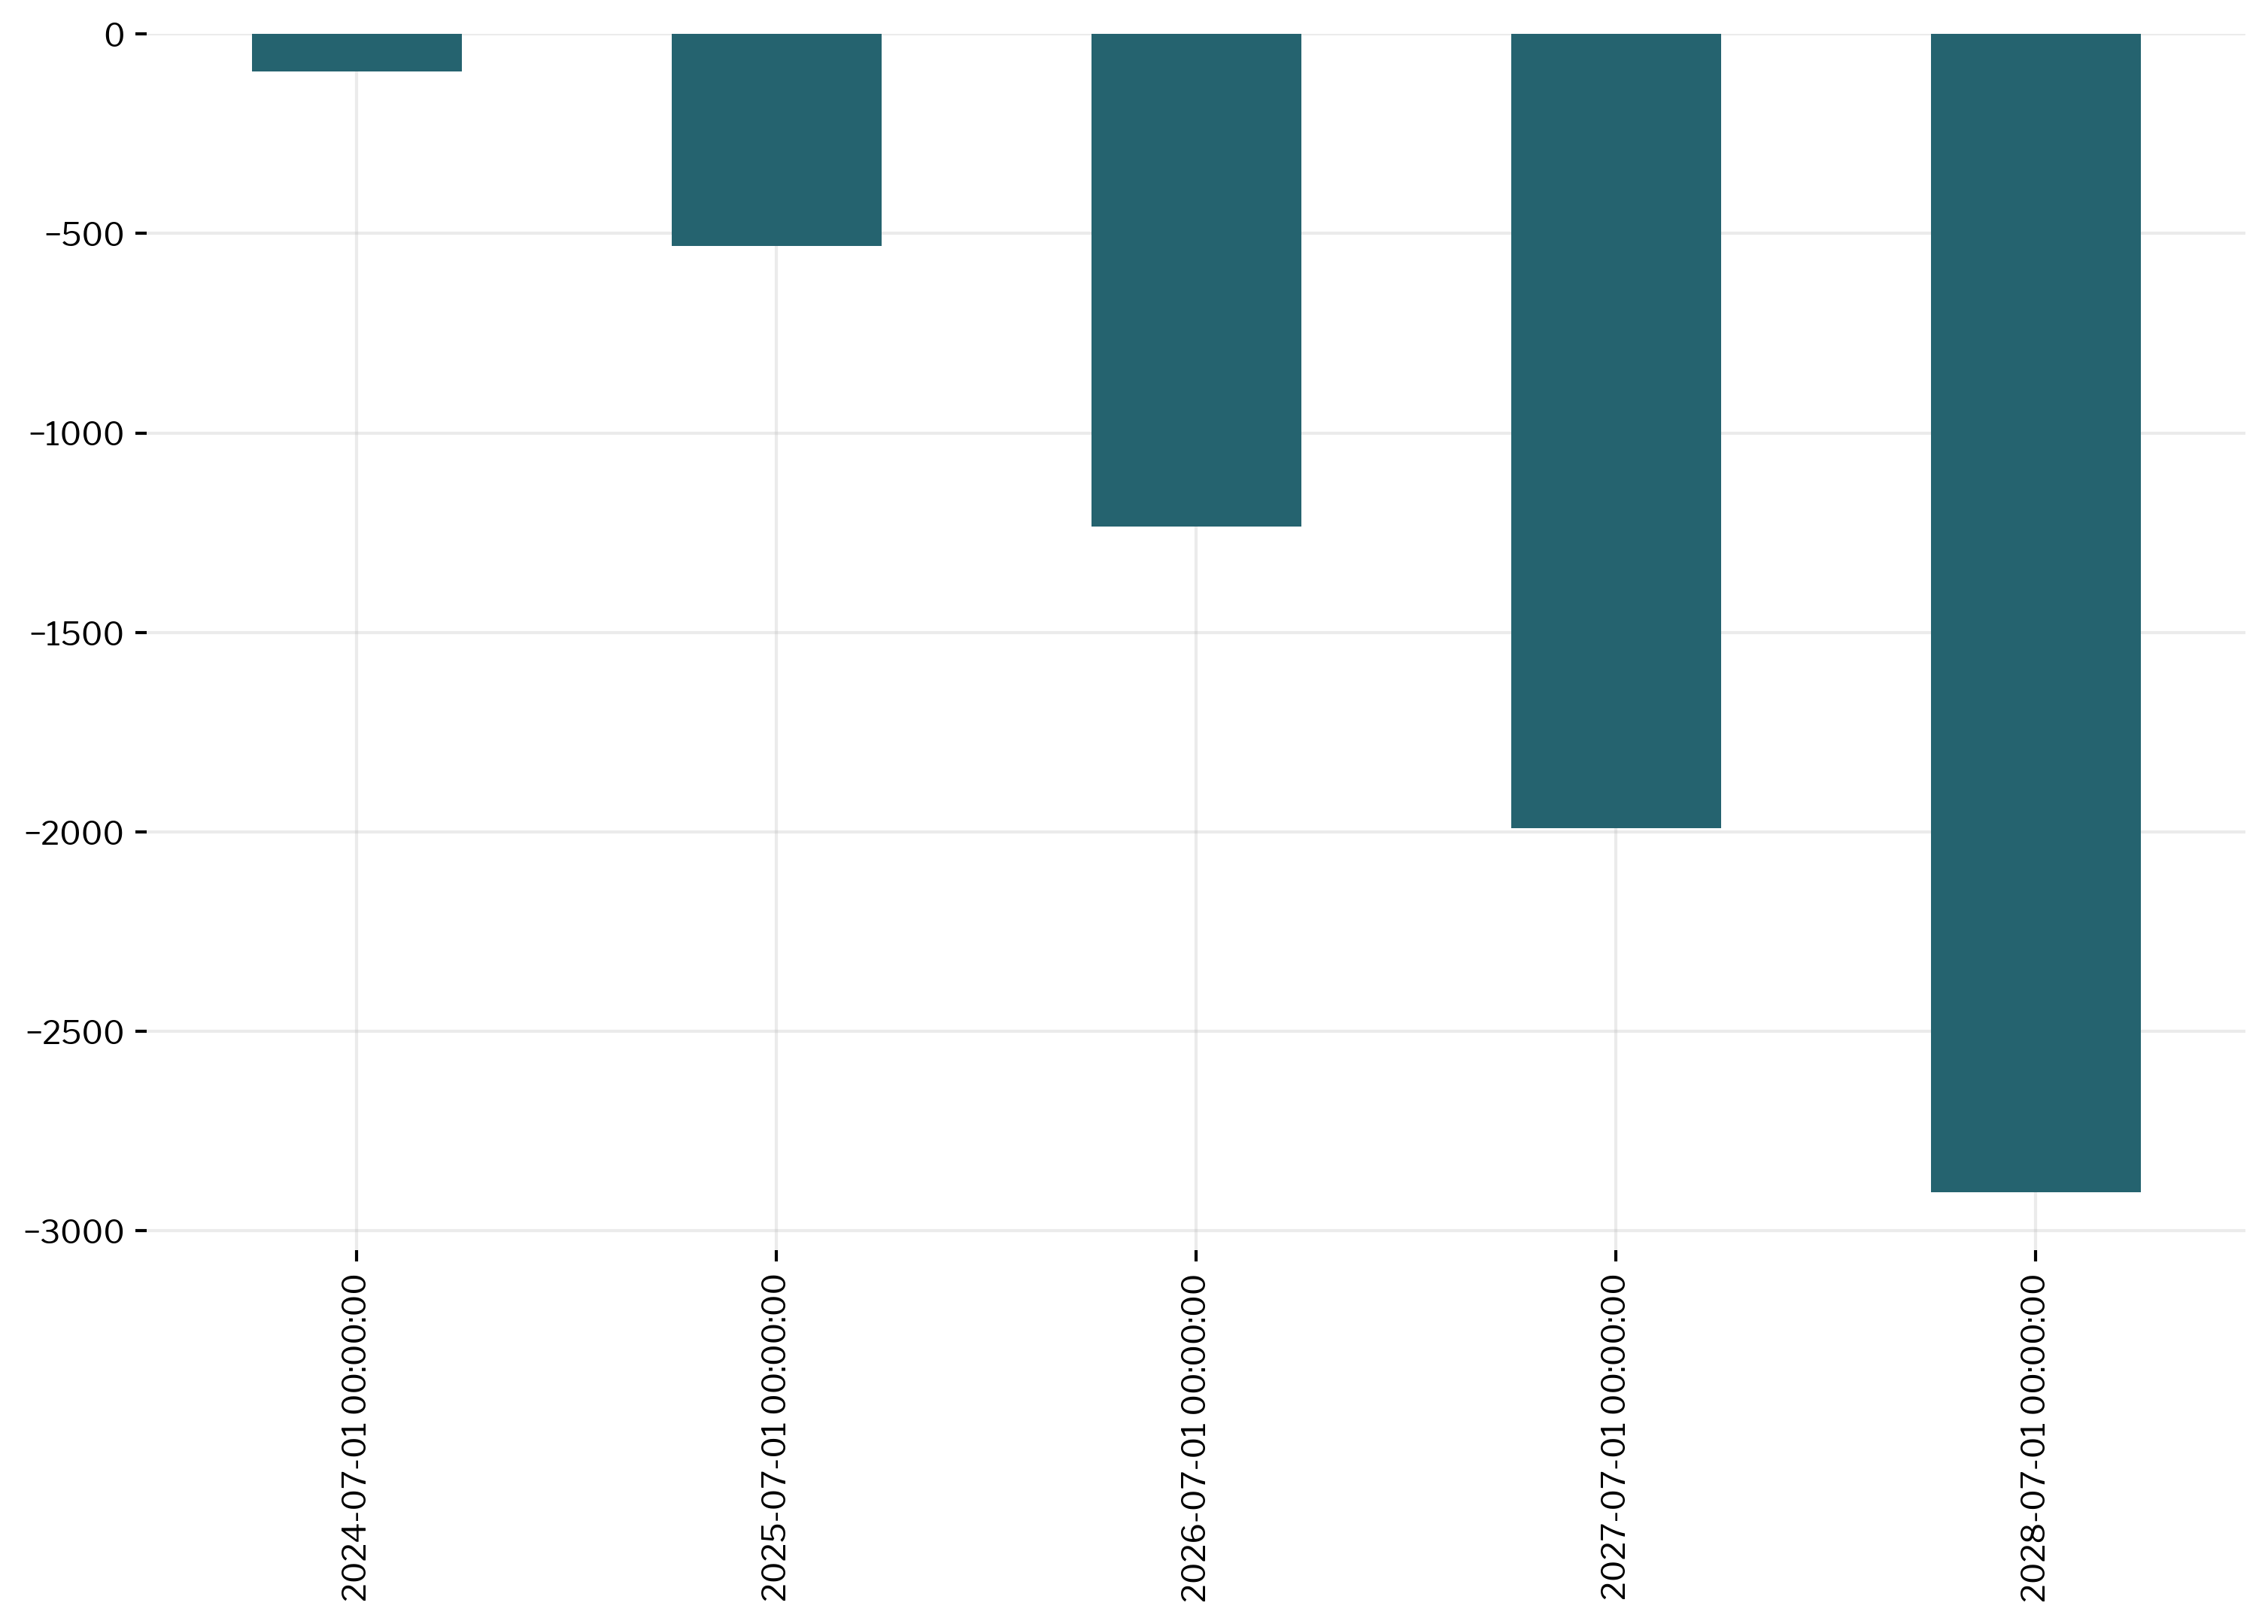

In [45]:
life_years = -totals.loc[
    pd.date_range(start="2024-07-01", end="2028-07-01", freq="AS-JUL")
].life_years_out_of_prison
life_years.plot.bar()
life_years

2024-07-01     1.751203
2025-07-01    10.003649
2026-07-01    23.245499
2027-07-01    37.444056
2028-07-01    54.639004
Freq: 12MS, Name: cost_savings_mil, dtype: float64

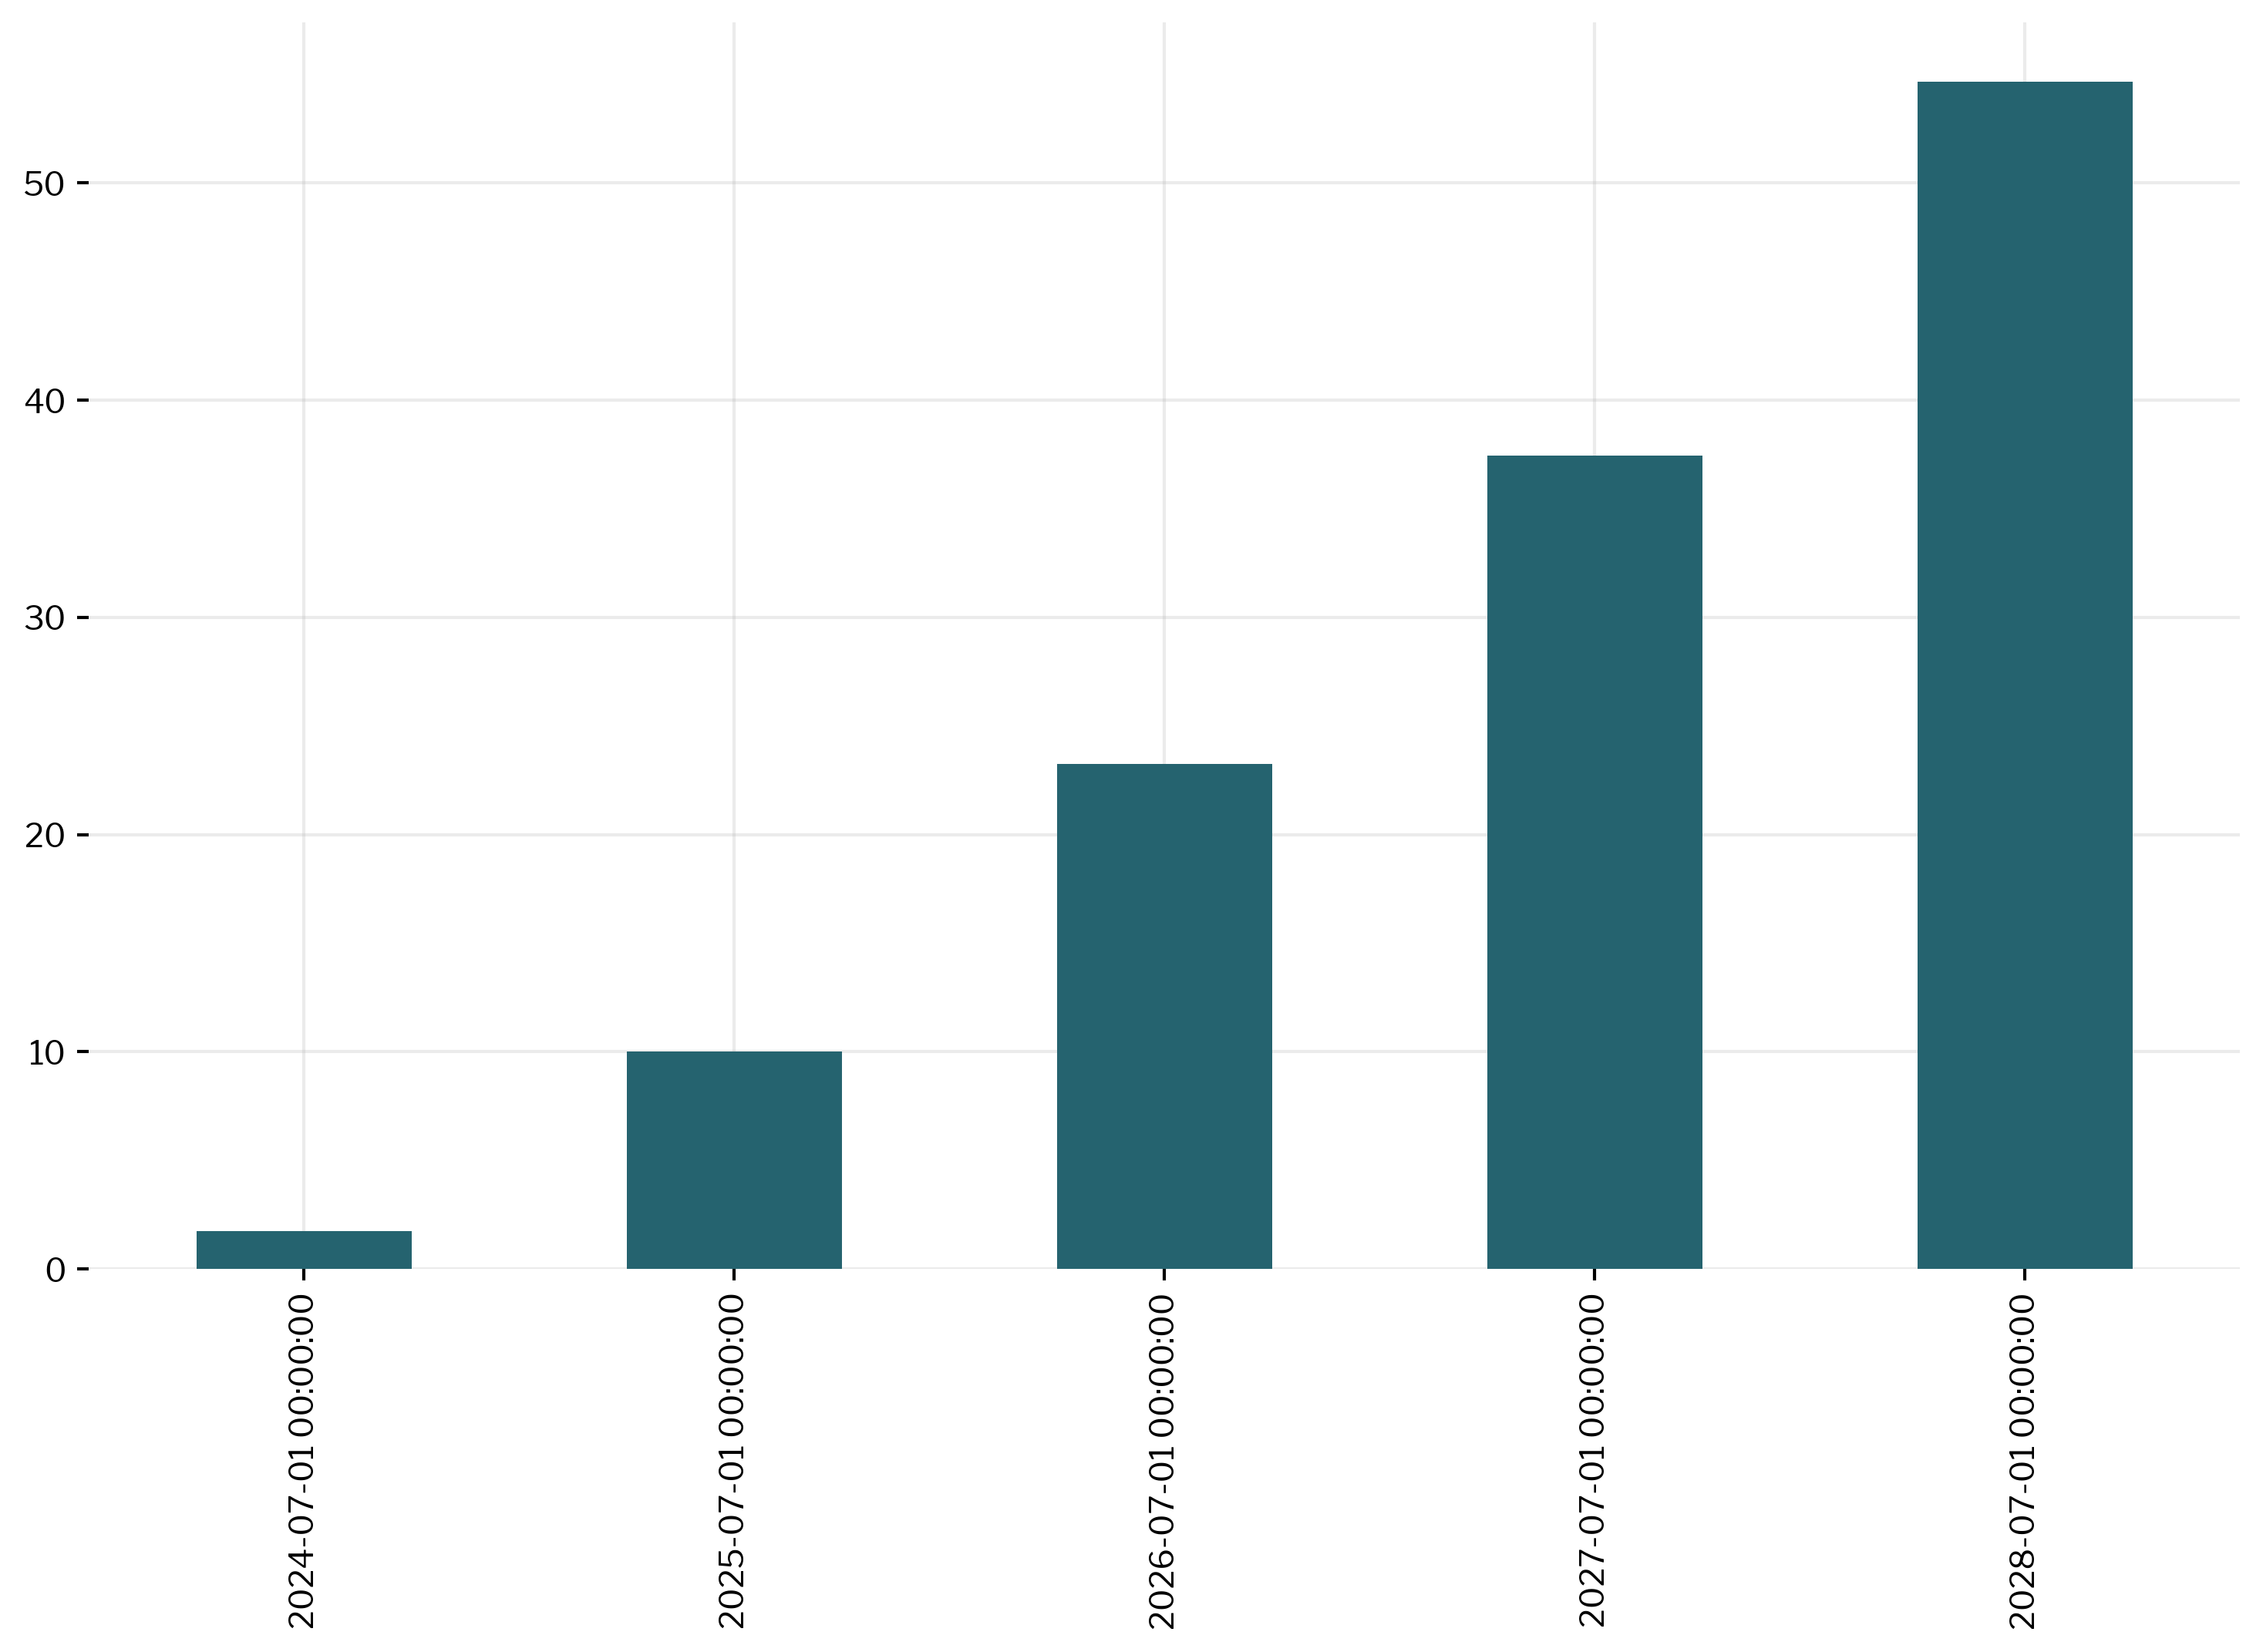

In [46]:
cost = totals.loc[
    pd.date_range(start="2024-07-01", end="2028-07-01", freq="AS-JUL")
].cost_savings_mil
cost.plot.bar()
cost

In [47]:
totals.loc[pd.date_range(start="2023-01-01", end="2033-01-01", freq="YS")]

,control,policy,difference,life_years_out_of_prison,cost_savings_mil
2023-01-01,7236.00,7236.00,0.00,0.00,0.000000
2024-01-01,7225.46,7162.56,62.90,8.20,0.154308
2025-01-01,7173.61,6749.80,423.81,268.05,5.044165
2026-01-01,7118.53,6399.09,719.44,876.96,16.502633
2027-01-01,7042.12,6303.39,738.73,1595.09,30.016404
2028-01-01,6943.53,6034.57,908.96,2426.50,45.661877
2029-01-01,6841.61,5784.39,1057.22,3420.45,64.366028
2030-01-01,6708.21,5603.69,1104.52,4507.31,84.818560
2031-01-01,6578.85,5432.71,1146.14,5639.22,106.118842
2032-01-01,6428.07,5320.19,1107.88,6765.37,127.310733


In [48]:
totals.loc[pd.date_range(start="2023-01-01", end="2035-01-01", freq="AS-JUL")]

,control,policy,difference,life_years_out_of_prison,cost_savings_mil
2023-07-01,7236.00,7236.00,0.00,0.00,0.000000
2024-07-01,7202.85,6957.37,245.48,93.06,1.751203
2025-07-01,7146.41,6545.80,600.61,531.60,10.003649
2026-07-01,7082.32,6367.30,715.02,1235.28,23.245499
2027-07-01,6993.83,6169.08,824.75,1989.80,37.444056
2028-07-01,6894.35,5905.01,989.34,2903.55,54.639004
2029-07-01,6779.19,5691.68,1087.51,3958.46,74.490300
2030-07-01,6643.48,5514.18,1129.30,5067.91,95.367930
2031-07-01,6503.19,5373.48,1129.71,6206.81,116.799751
2032-07-01,6354.96,5266.94,1088.02,7314.11,137.636922


2024-07-01     -93.06
2025-07-01    -531.60
2026-07-01   -1235.28
2027-07-01   -1989.80
2028-07-01   -2903.55
Freq: 12MS, Name: life_years_out_of_prison, dtype: float64

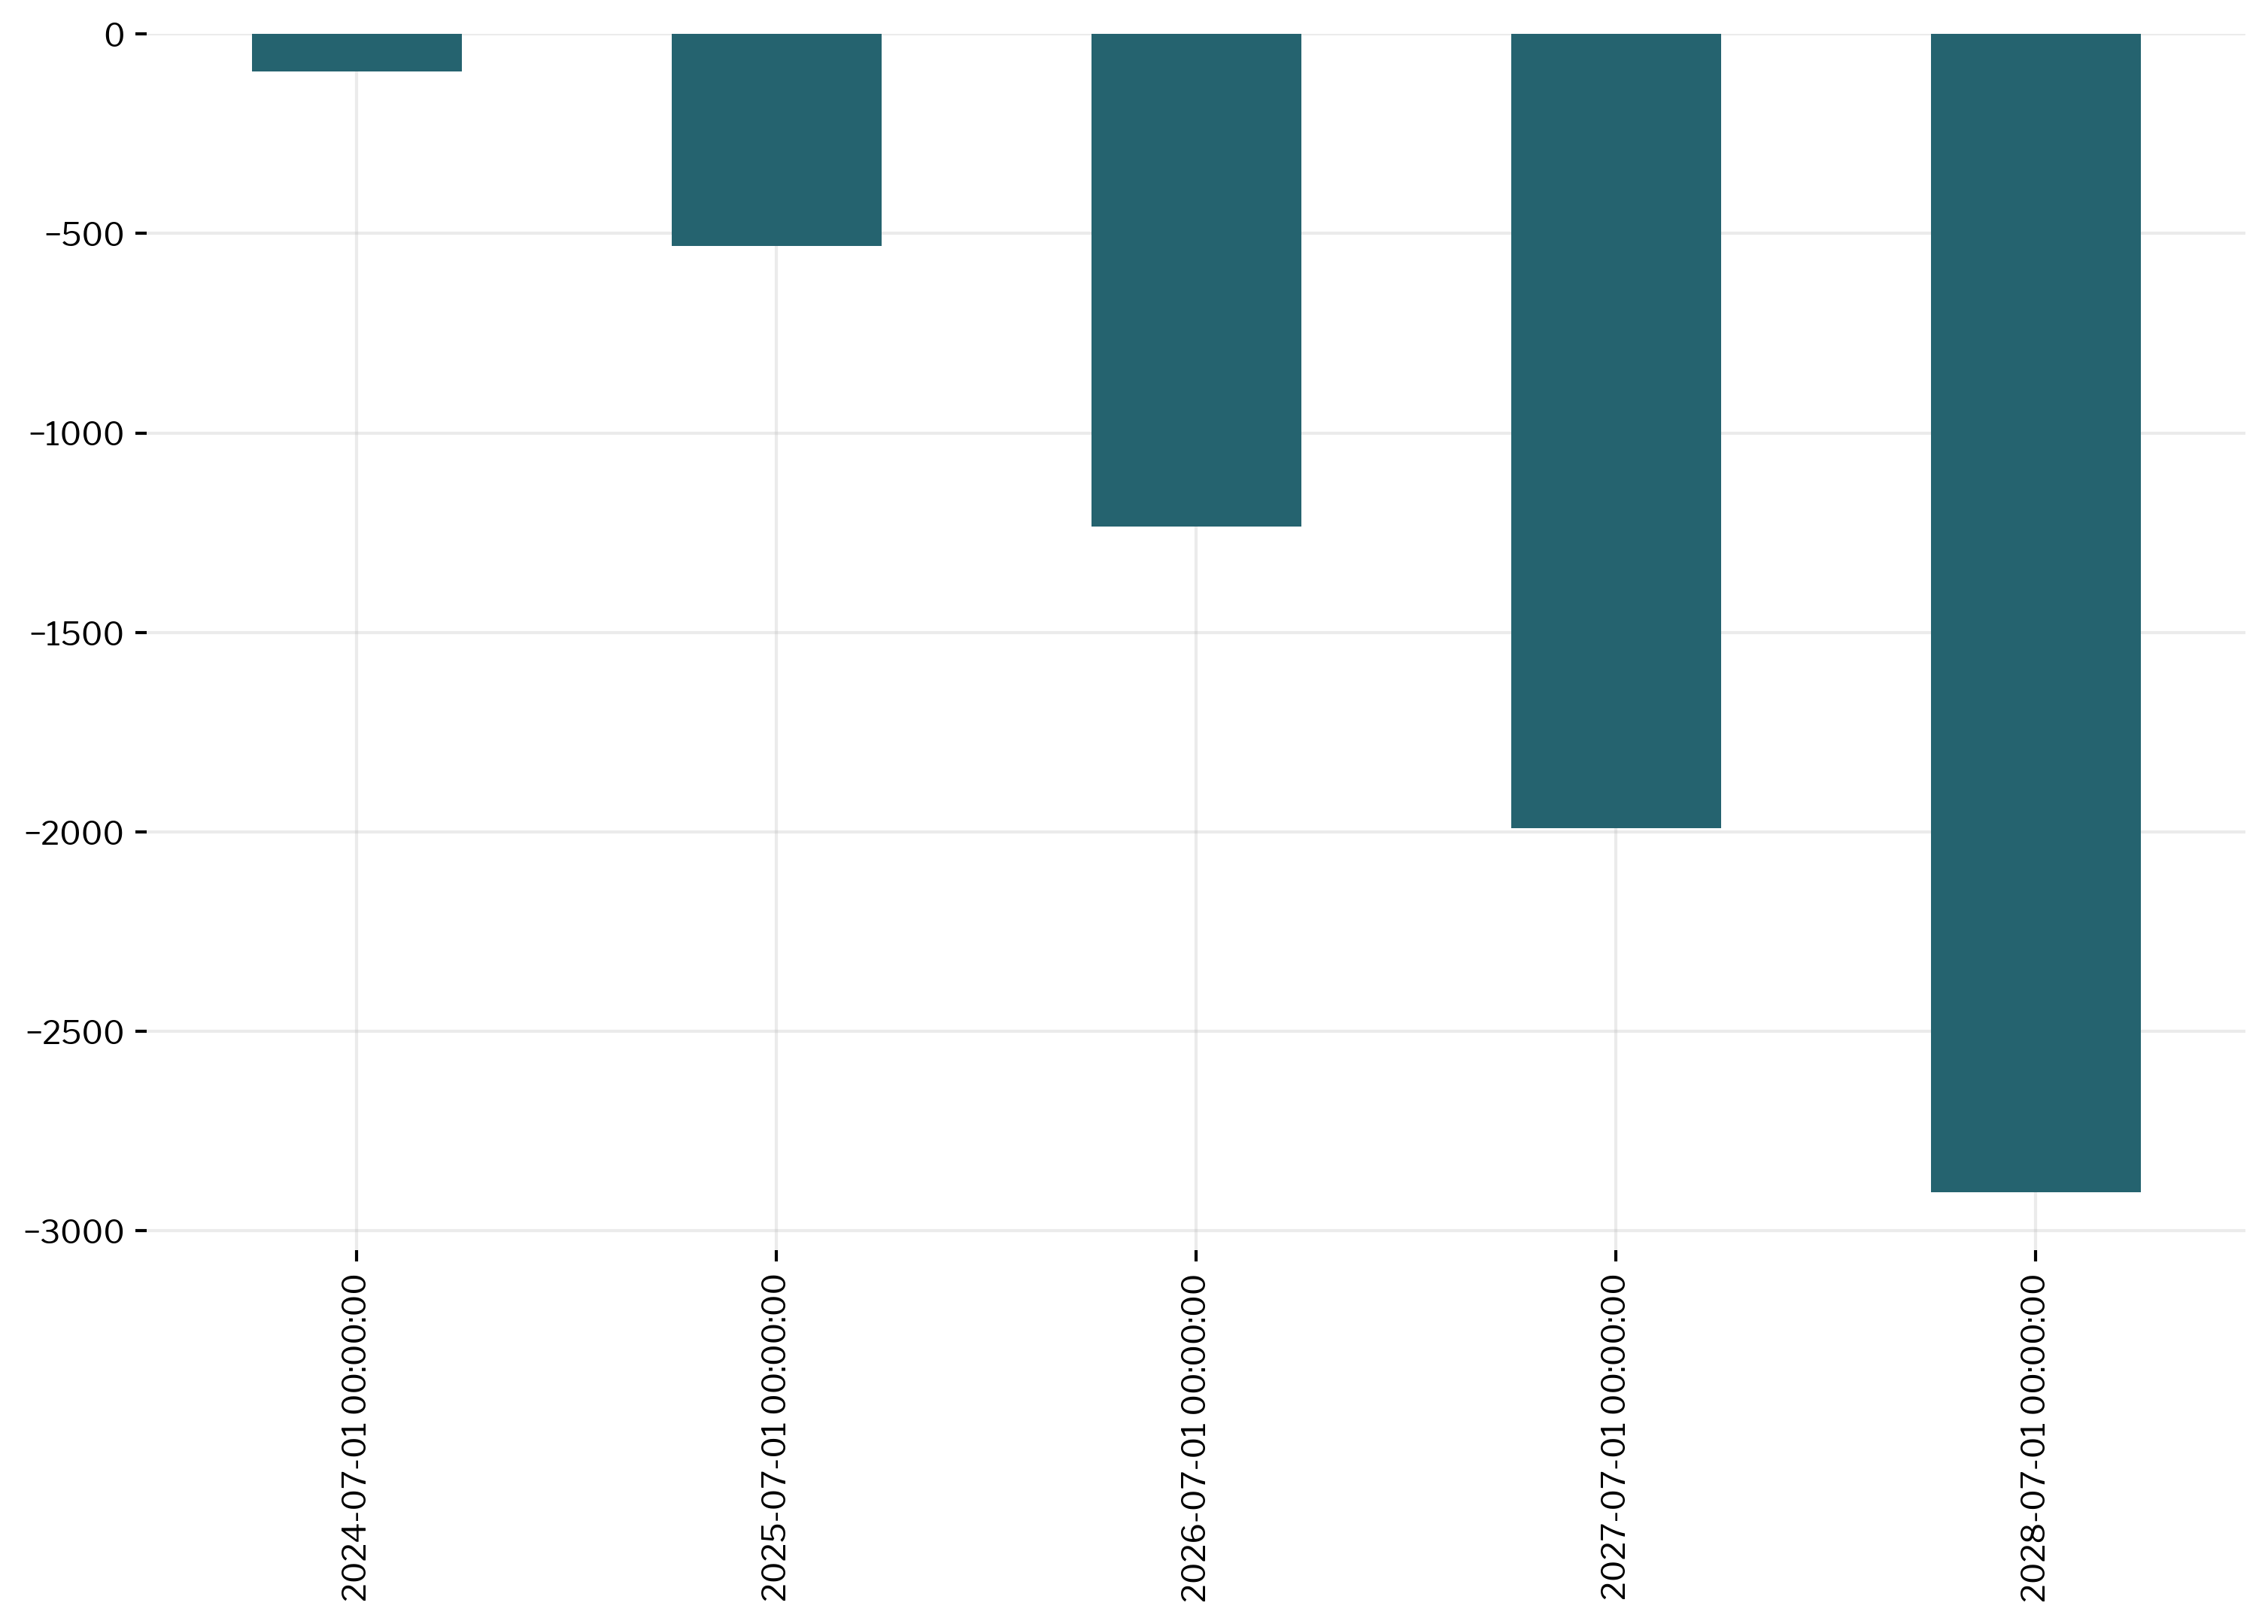

In [49]:
life_years = -totals.loc[
    pd.date_range(start="2024-07-01", end="2028-07-01", freq="AS-JUL")
].life_years_out_of_prison
life_years.plot.bar()
life_years

2024-07-01     1.751203
2025-07-01    10.003649
2026-07-01    23.245499
2027-07-01    37.444056
2028-07-01    54.639004
Freq: 12MS, Name: cost_savings_mil, dtype: float64

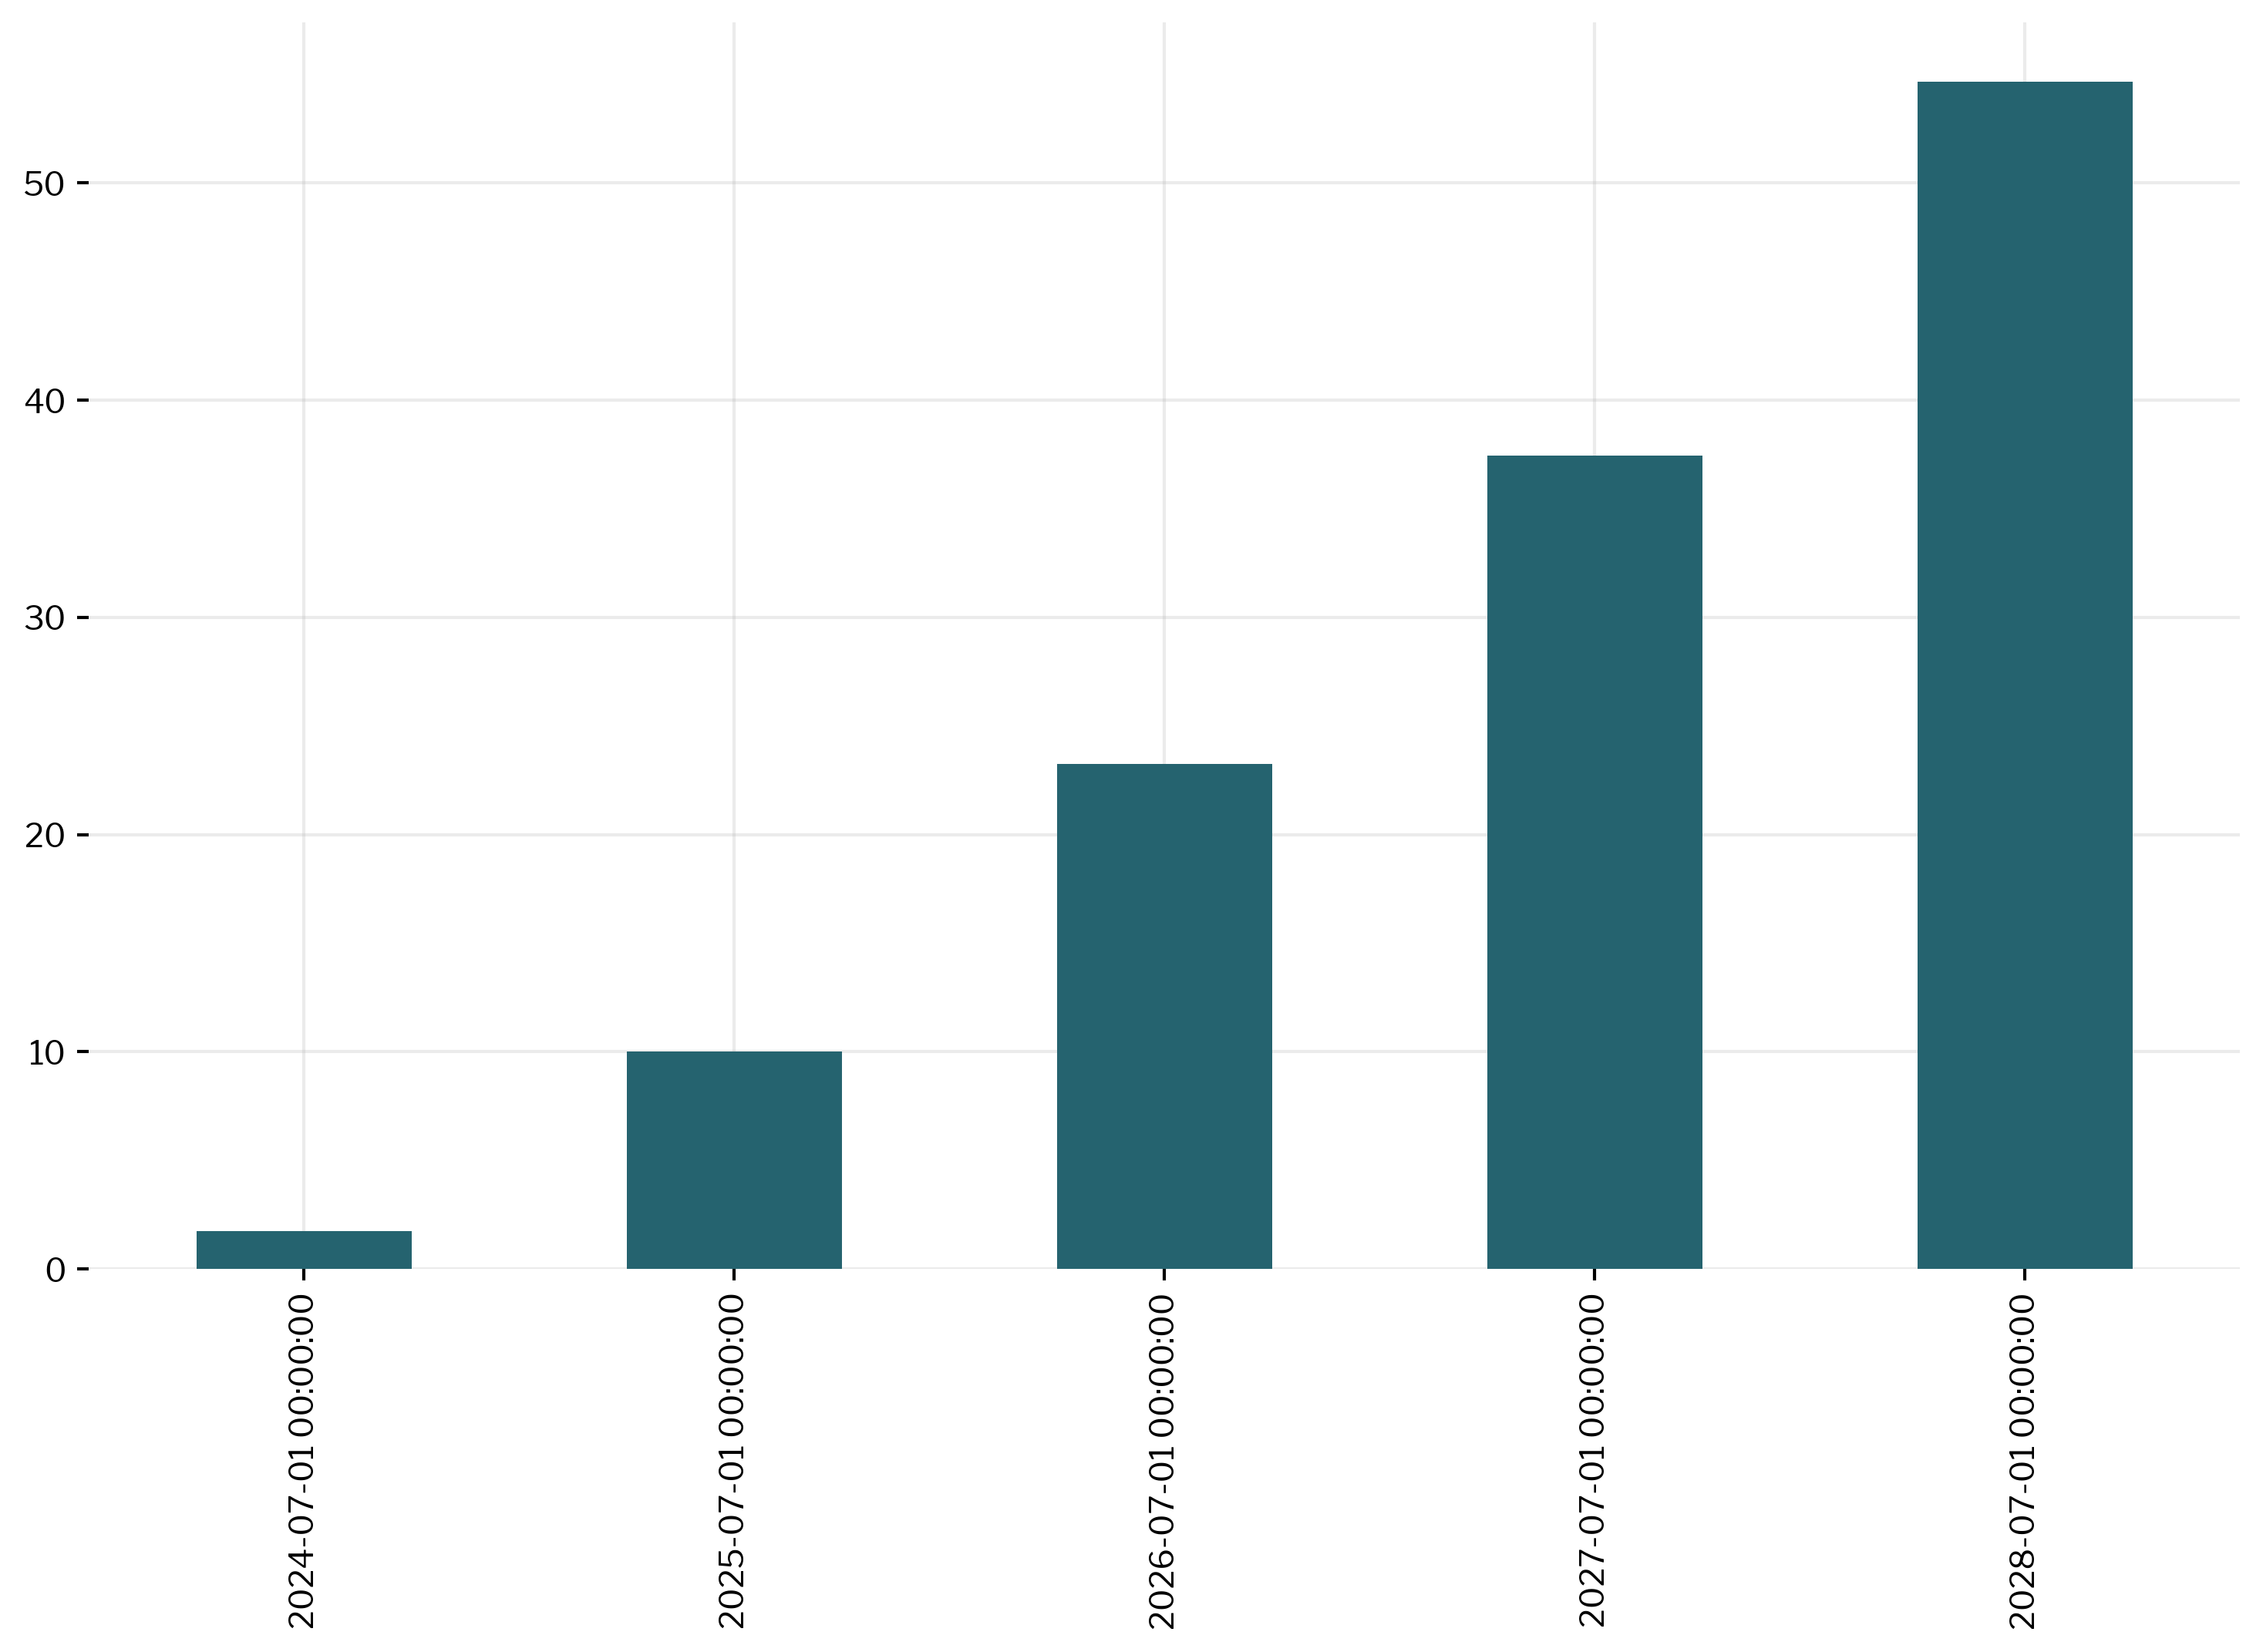

In [50]:
cost = totals.loc[
    pd.date_range(start="2024-07-01", end="2028-07-01", freq="AS-JUL")
].cost_savings_mil
cost.plot.bar()
cost

## visualizations

#### Immediately eligible population releases by month

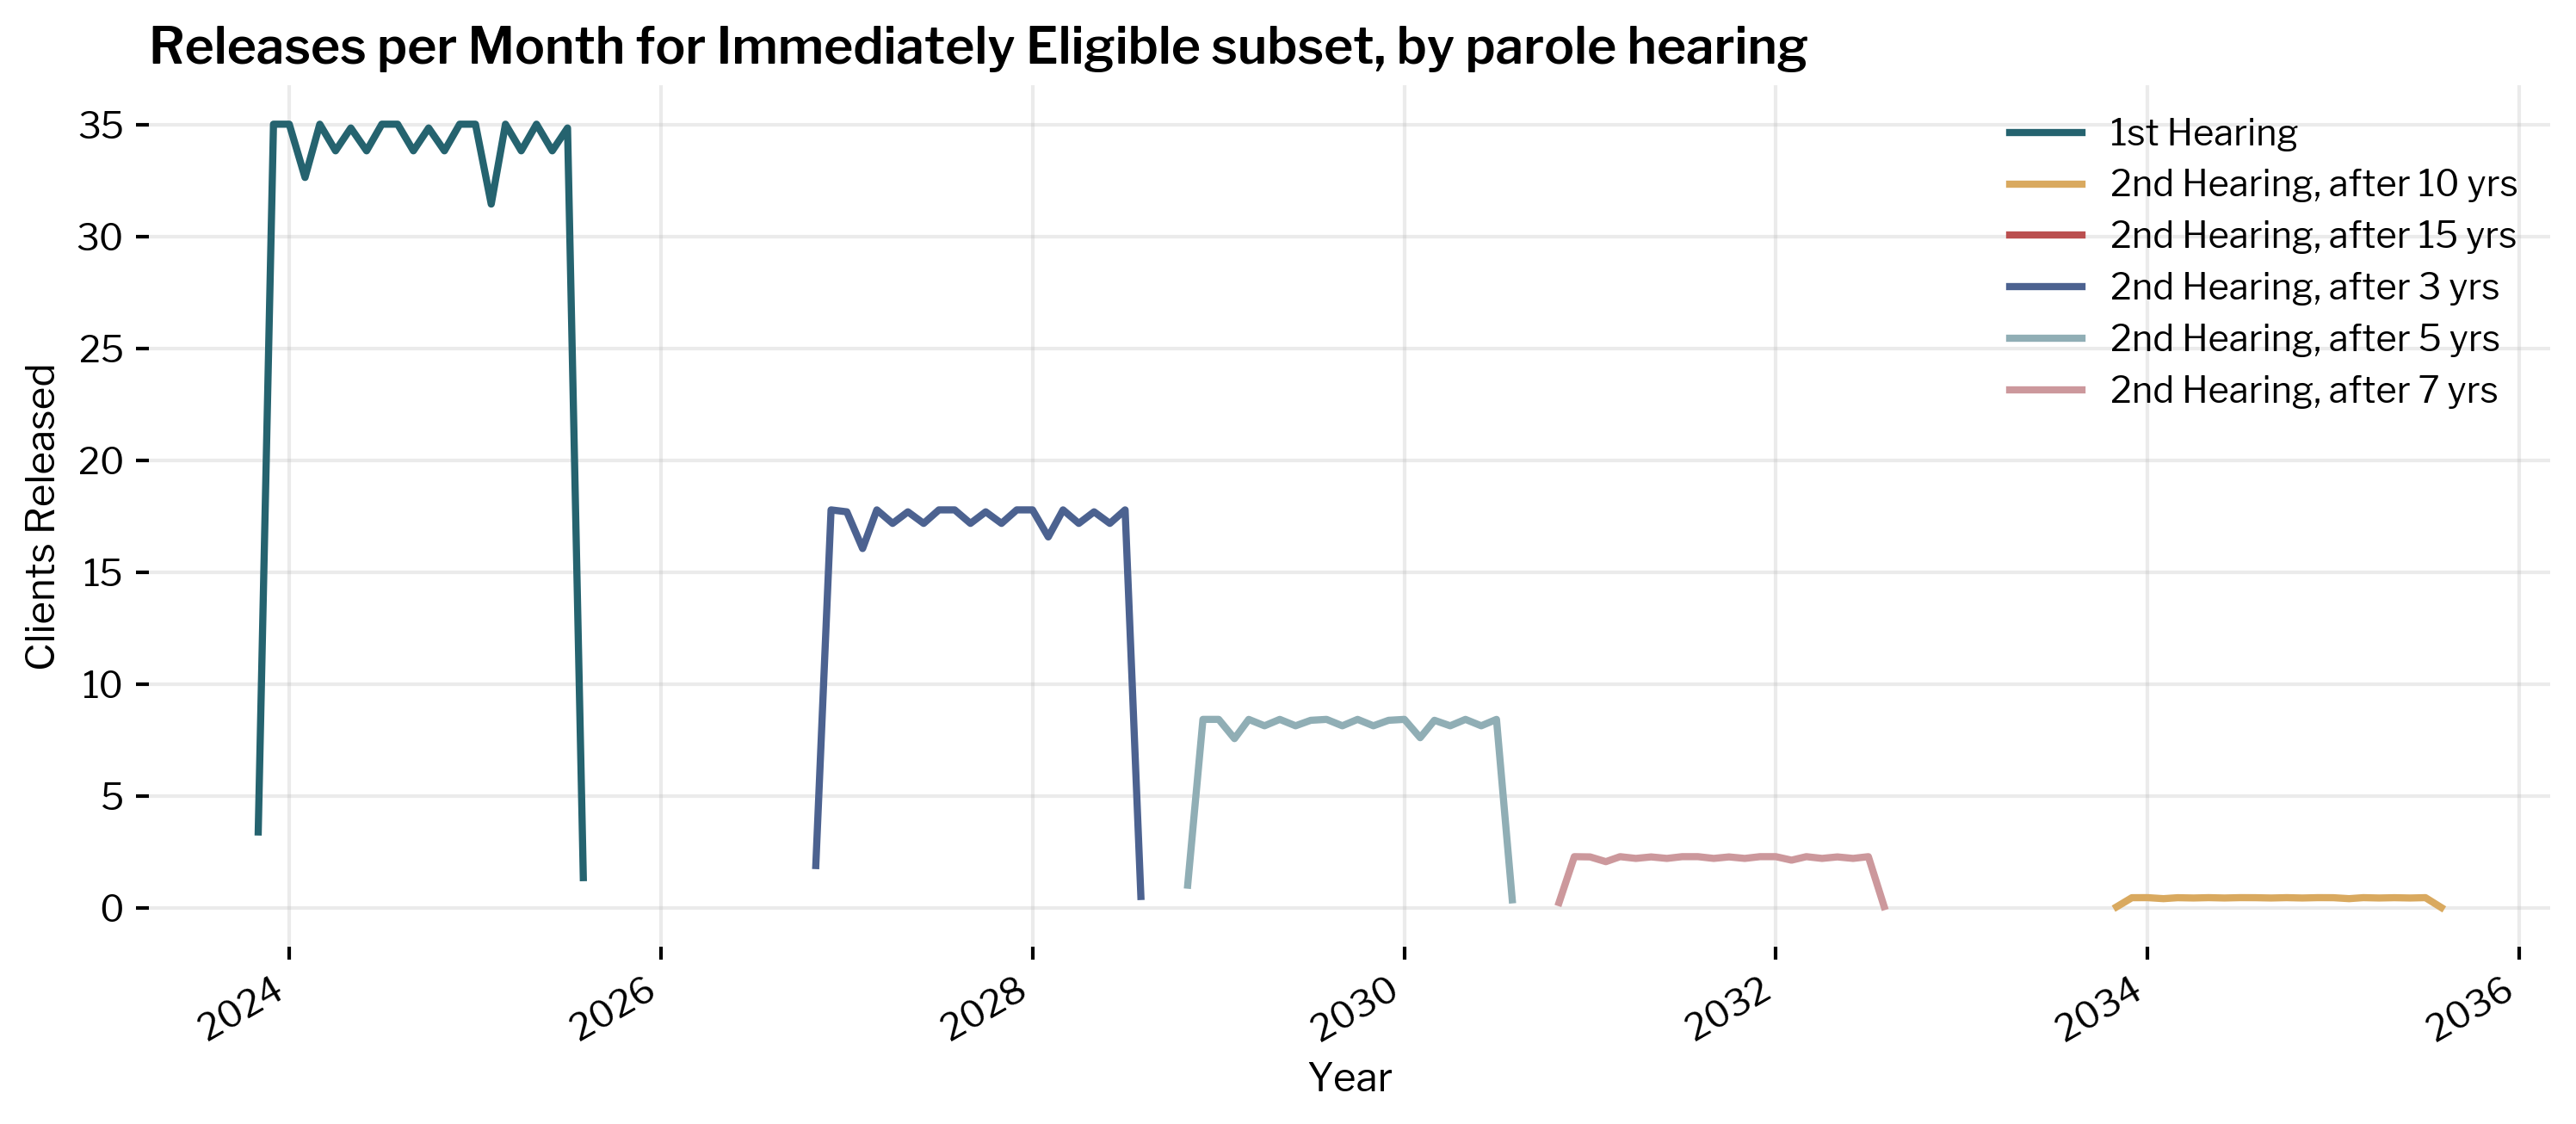

In [106]:
x = (
    cas[cas.immediately_eligible]
    .groupby(["release_month_policy", "hearing_label"])[["percent_outflow"]]
    .sum()
    .reindex(
        pd.date_range(
            start="2023-01-01", end=cas.release_month_policy.max(), freq="MS"
        ),
        level=0,
    )
    .fillna(0)
    .reset_index()
    .pivot(index="release_month_policy", columns="hearing_label")
    .loc[:"2036-01-01"]
)
x.columns = x.columns.droplevel(0).rename("")
x.plot()
plt.title("Releases per Month for Immediately Eligible subset, by parole hearing")
plt.xlabel("Year")
plt.ylabel("Clients Released")
plt.gca().set_aspect(44);

#### releases by eligibility subset by month

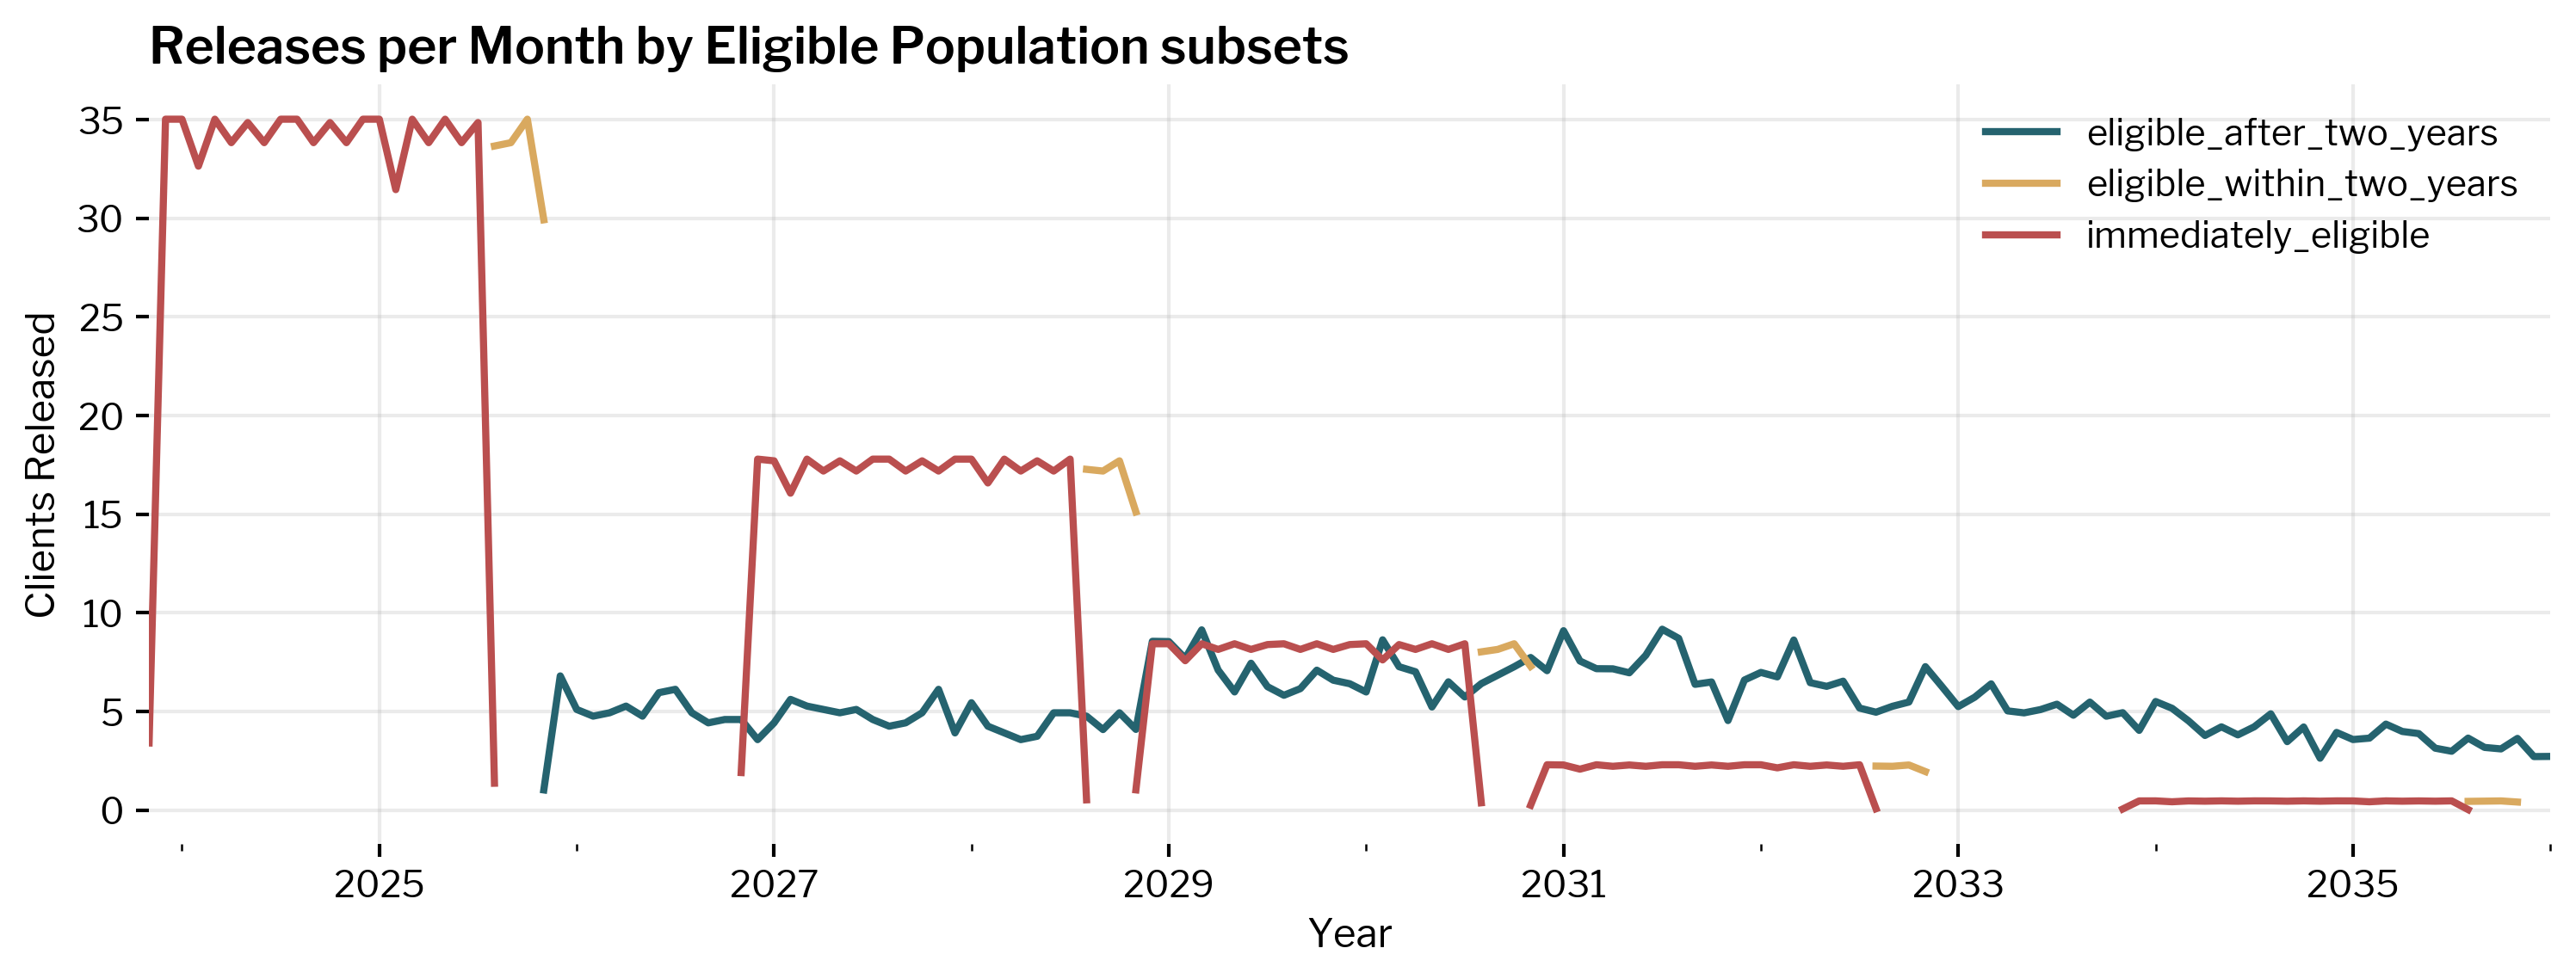

In [111]:
x = (
    cas.groupby(["release_month_policy", "subset"])[["percent_outflow"]]
    .sum()
    .reindex(
        pd.date_range(
            start="2023-01-01", end=cas.release_month_policy.max(), freq="MS"
        ),
        level=0,
    )
    .fillna(0)
    .reset_index()
    .pivot(index="release_month_policy", columns="subset")
    .loc[:"2036-01-01"]
)
x.columns = x.columns.droplevel(0).rename("")
x.plot()
plt.title("Releases per Month by eligible population subsets")
plt.xlabel("Year")
plt.ylabel("Clients Released")
plt.gca().set_aspect(1.2);

In [53]:
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, 3))

### start date to parole date to release date

In [114]:
def get_date_plot(date_field, categories, title, rescale=True):
    x = (
        cas.groupby([cas[date_field].dt.to_period("M").dt.to_timestamp()] + categories)[
            ["percent_outflow"]
        ]
        .sum()
        .reindex(
            pd.date_range(start="1990-01-01", end=cas[date_field].max(), freq="MS"),
            level=0,
        )
        .fillna(0)
        .reset_index()
        .pivot(index=date_field, columns=categories)
        .loc[:"2039-01-01"]
    )
    x.columns = x.columns.droplevel(0).rename("")
    x = x.reindex(pd.date_range(start="1997-01-01", end="2040-01-01", freq="MS"))
    x.plot()
    plt.title(title)
    if rescale:
        plt.xlim(pd.to_datetime("1997-01-01"), pd.to_datetime("2040-01-01"))
    plt.xlabel("Year")
    plt.gca().set_aspect(8);

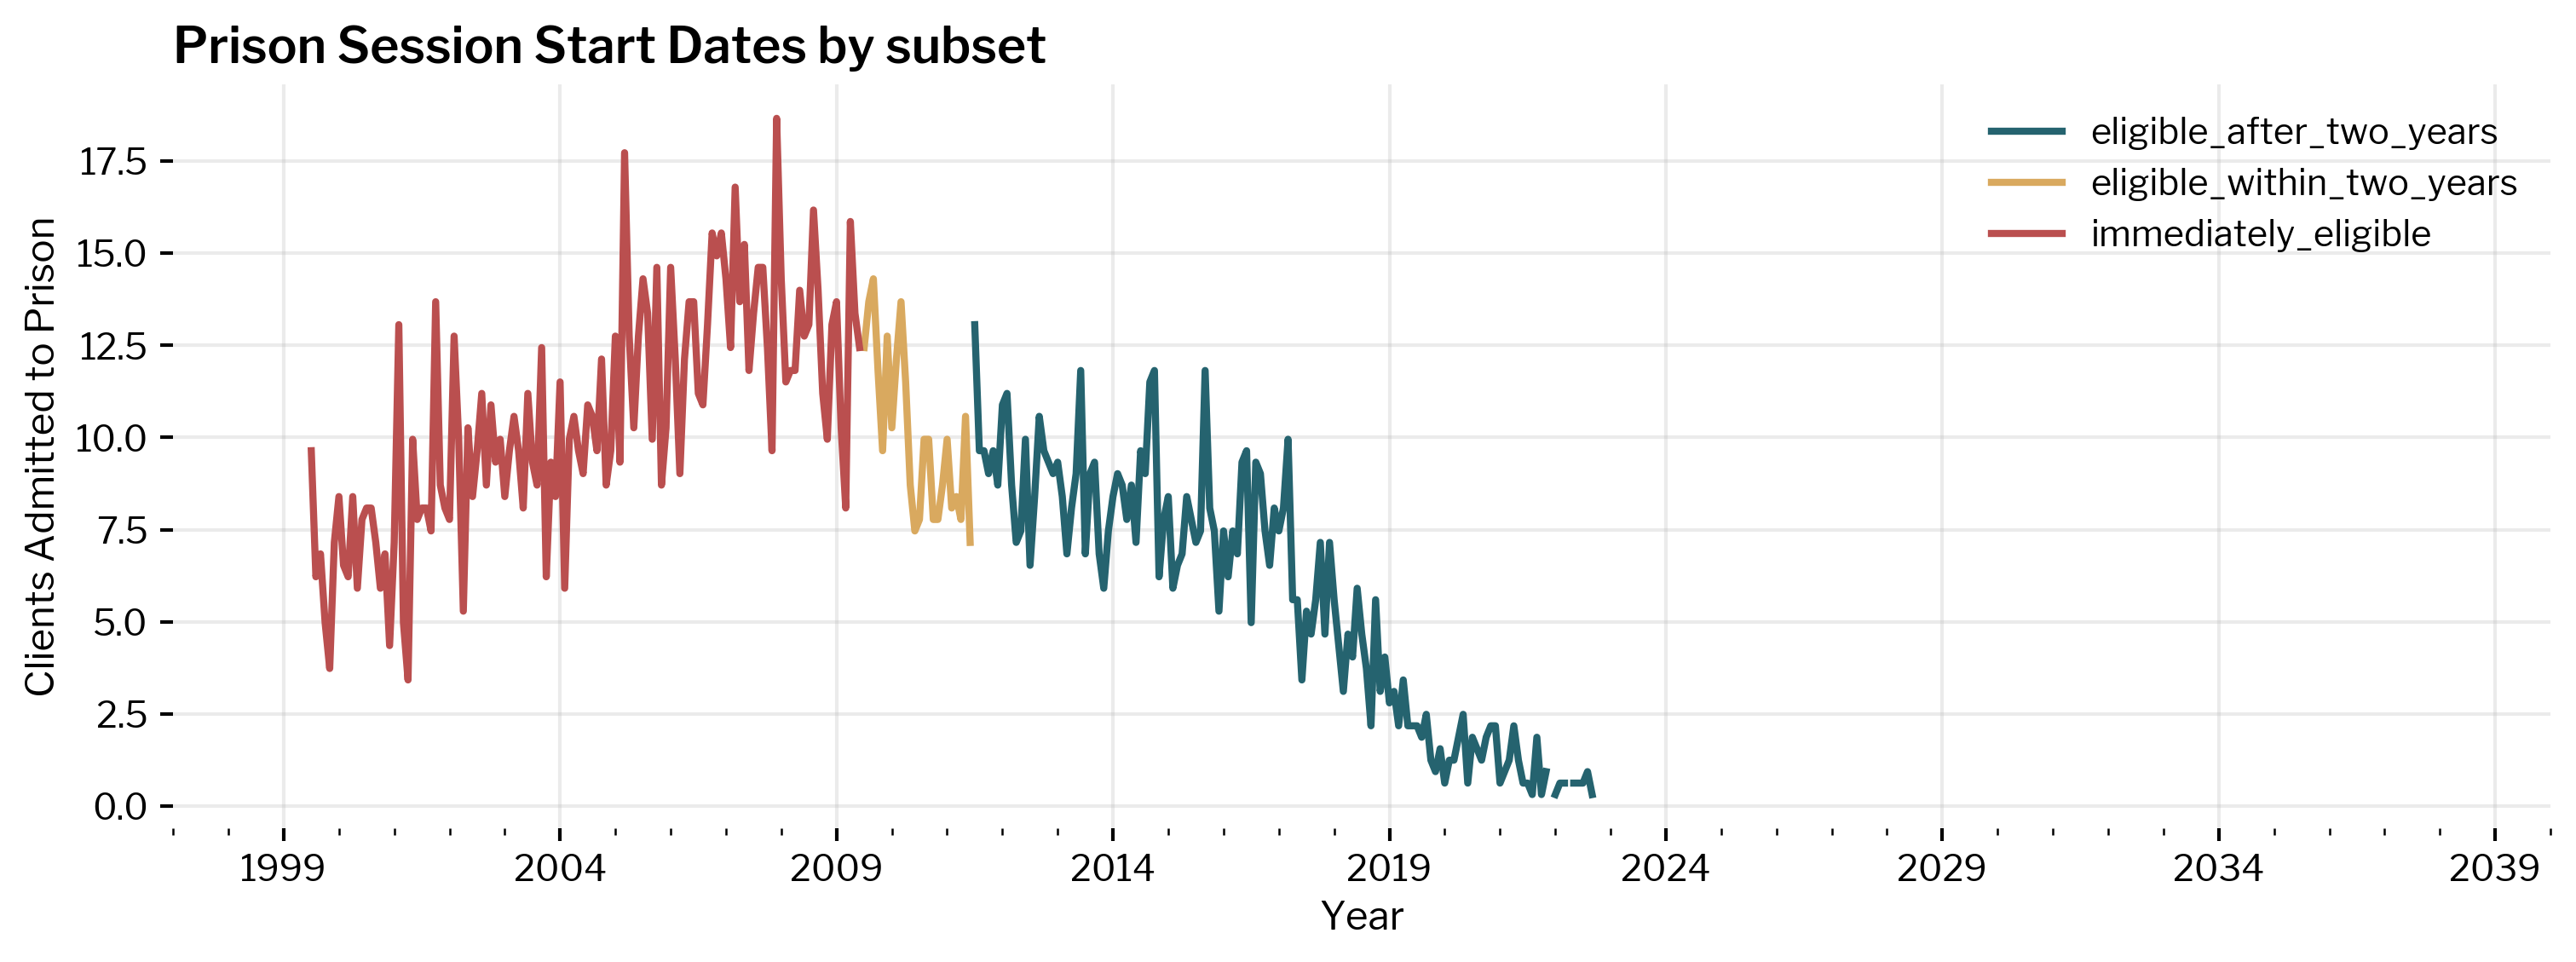

In [116]:
get_date_plot("start_date_calc", ["subset"], "Prison Session Start Dates by subset")
plt.ylabel("Clients Admitted to Prison");

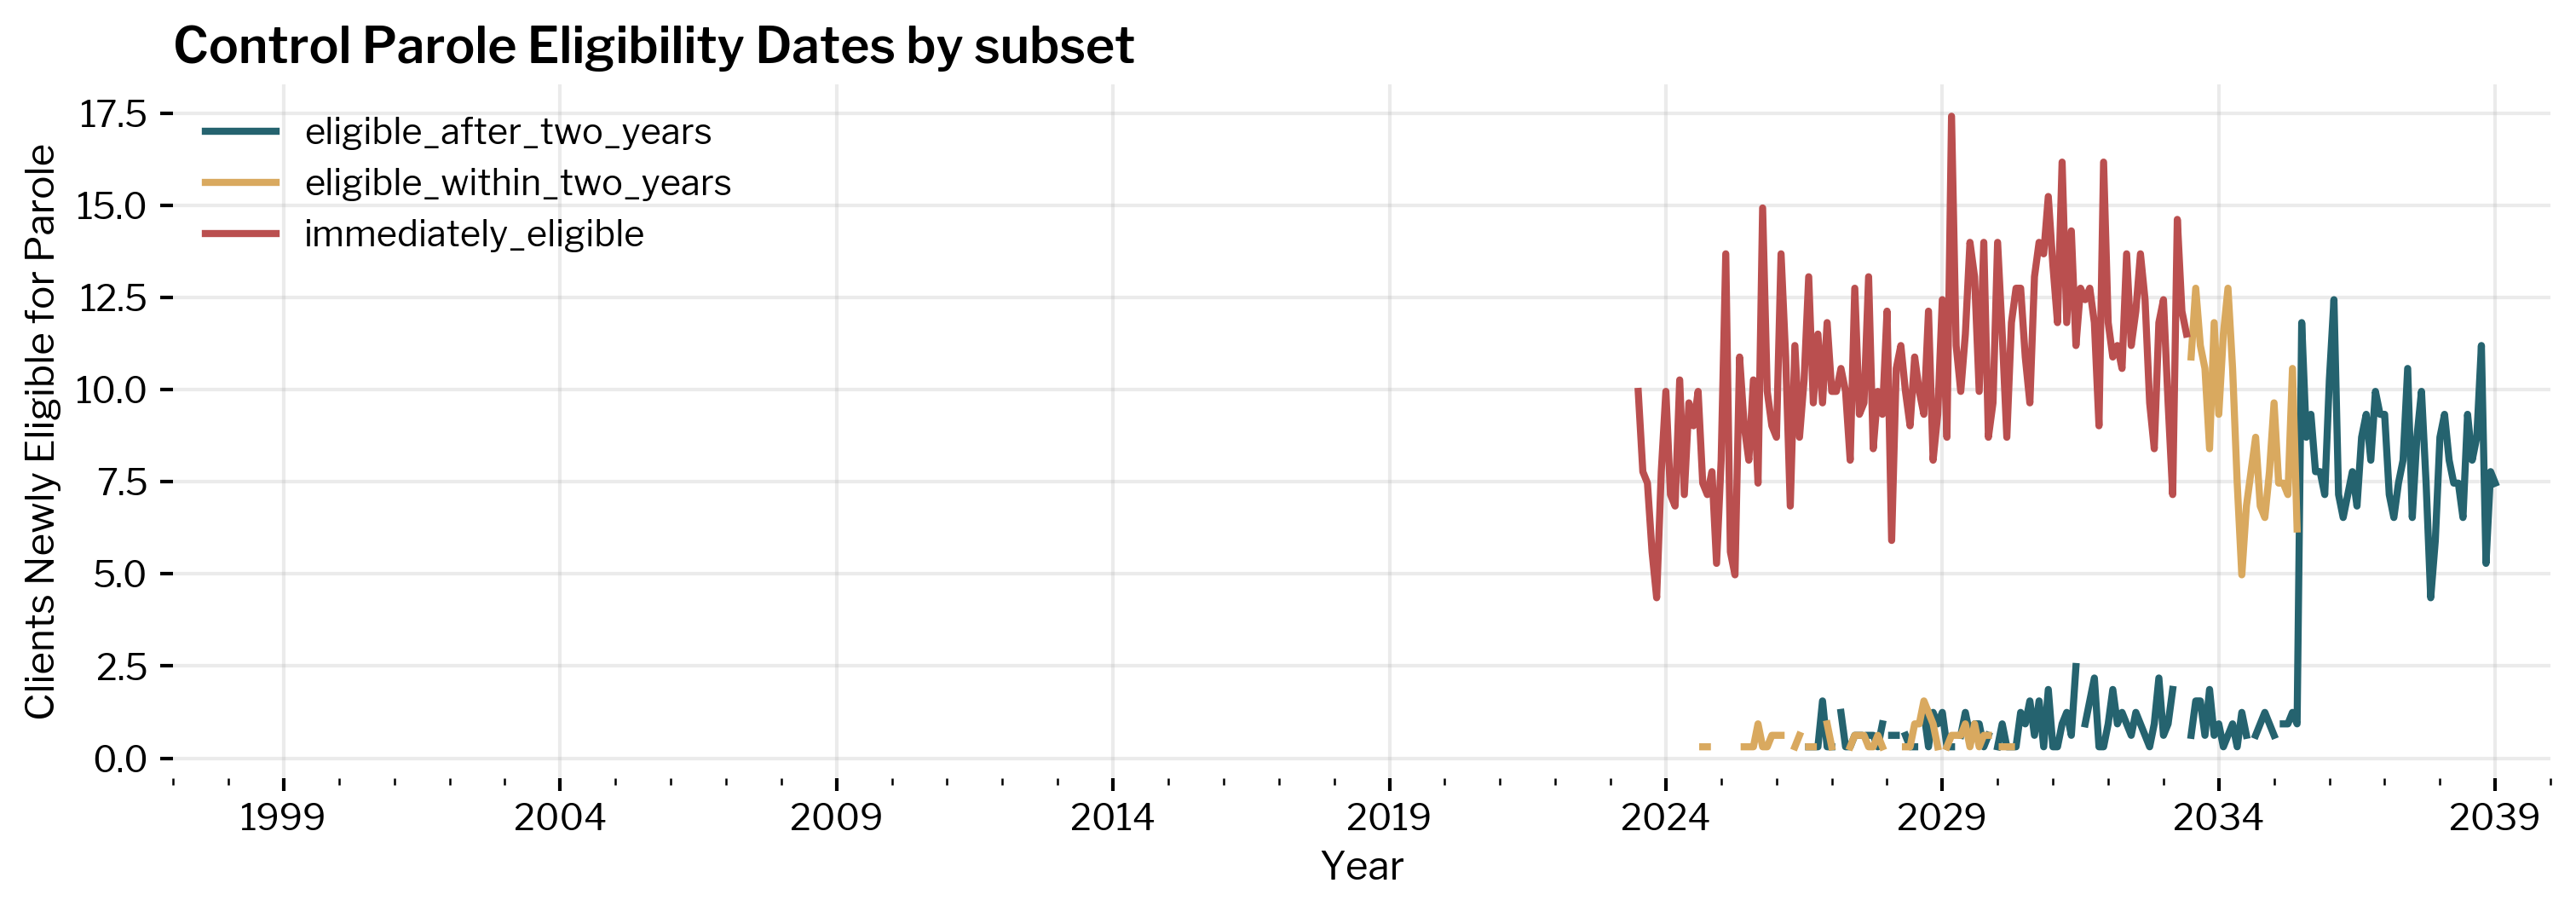

In [117]:
t = get_date_plot(
    "parole_eligibility_date_control",
    ["subset"],
    "Control Parole Eligibility Dates by subset",
)
plt.ylabel("Clients Newly Eligible for Parole");

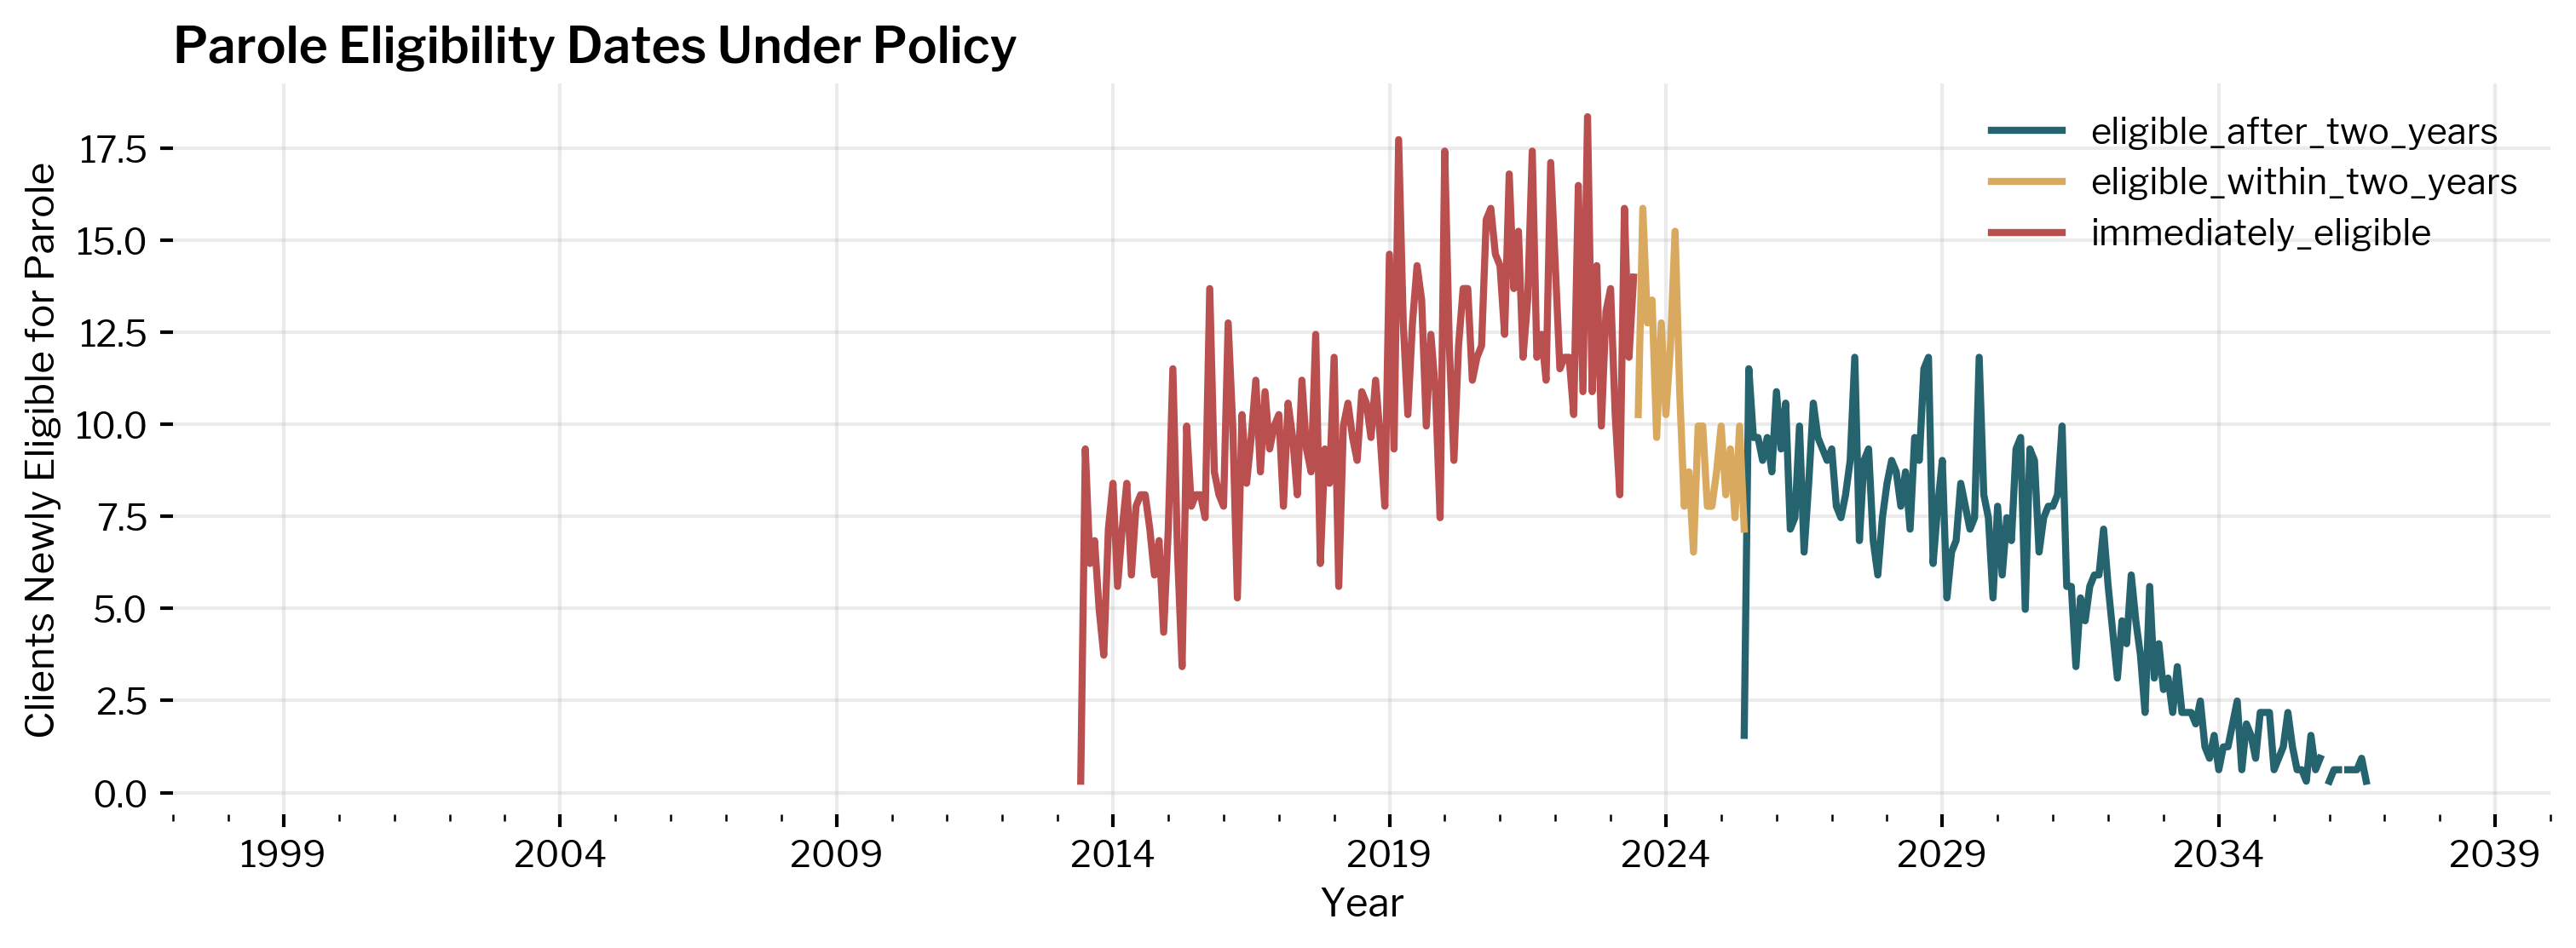

In [119]:
v = get_date_plot(
    "parole_eligibility_date_policy",
    ["subset"],
    "Parole Eligibility Dates Under Policy",
)
plt.ylabel("Clients Newly Eligible for Parole");

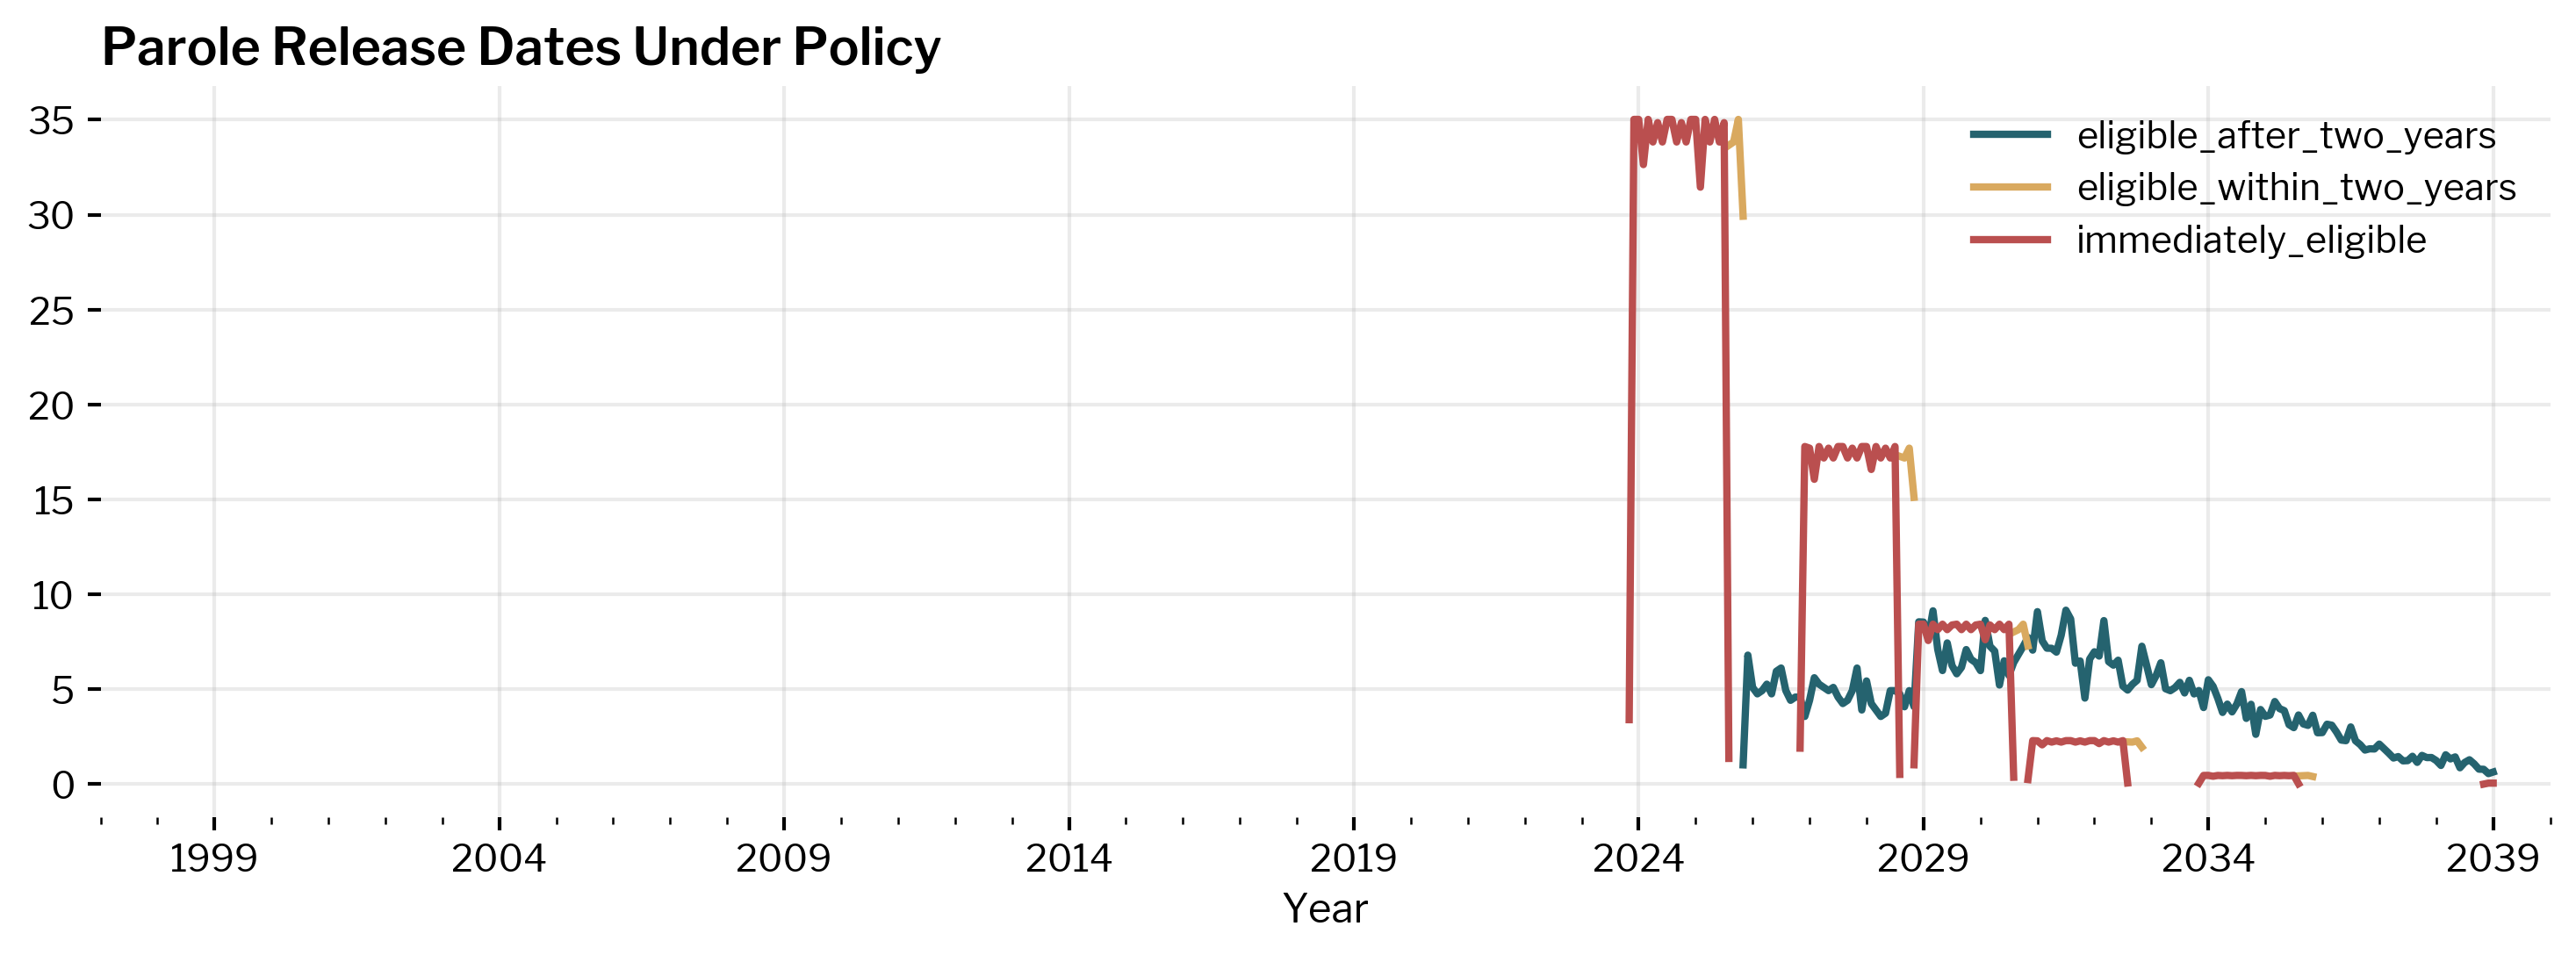

In [59]:
get_date_plot("release_date_policy", ["subset"], "Parole Release Dates Under Policy")
plt.gca().set_aspect(4);

#### Raw number of hearings per month

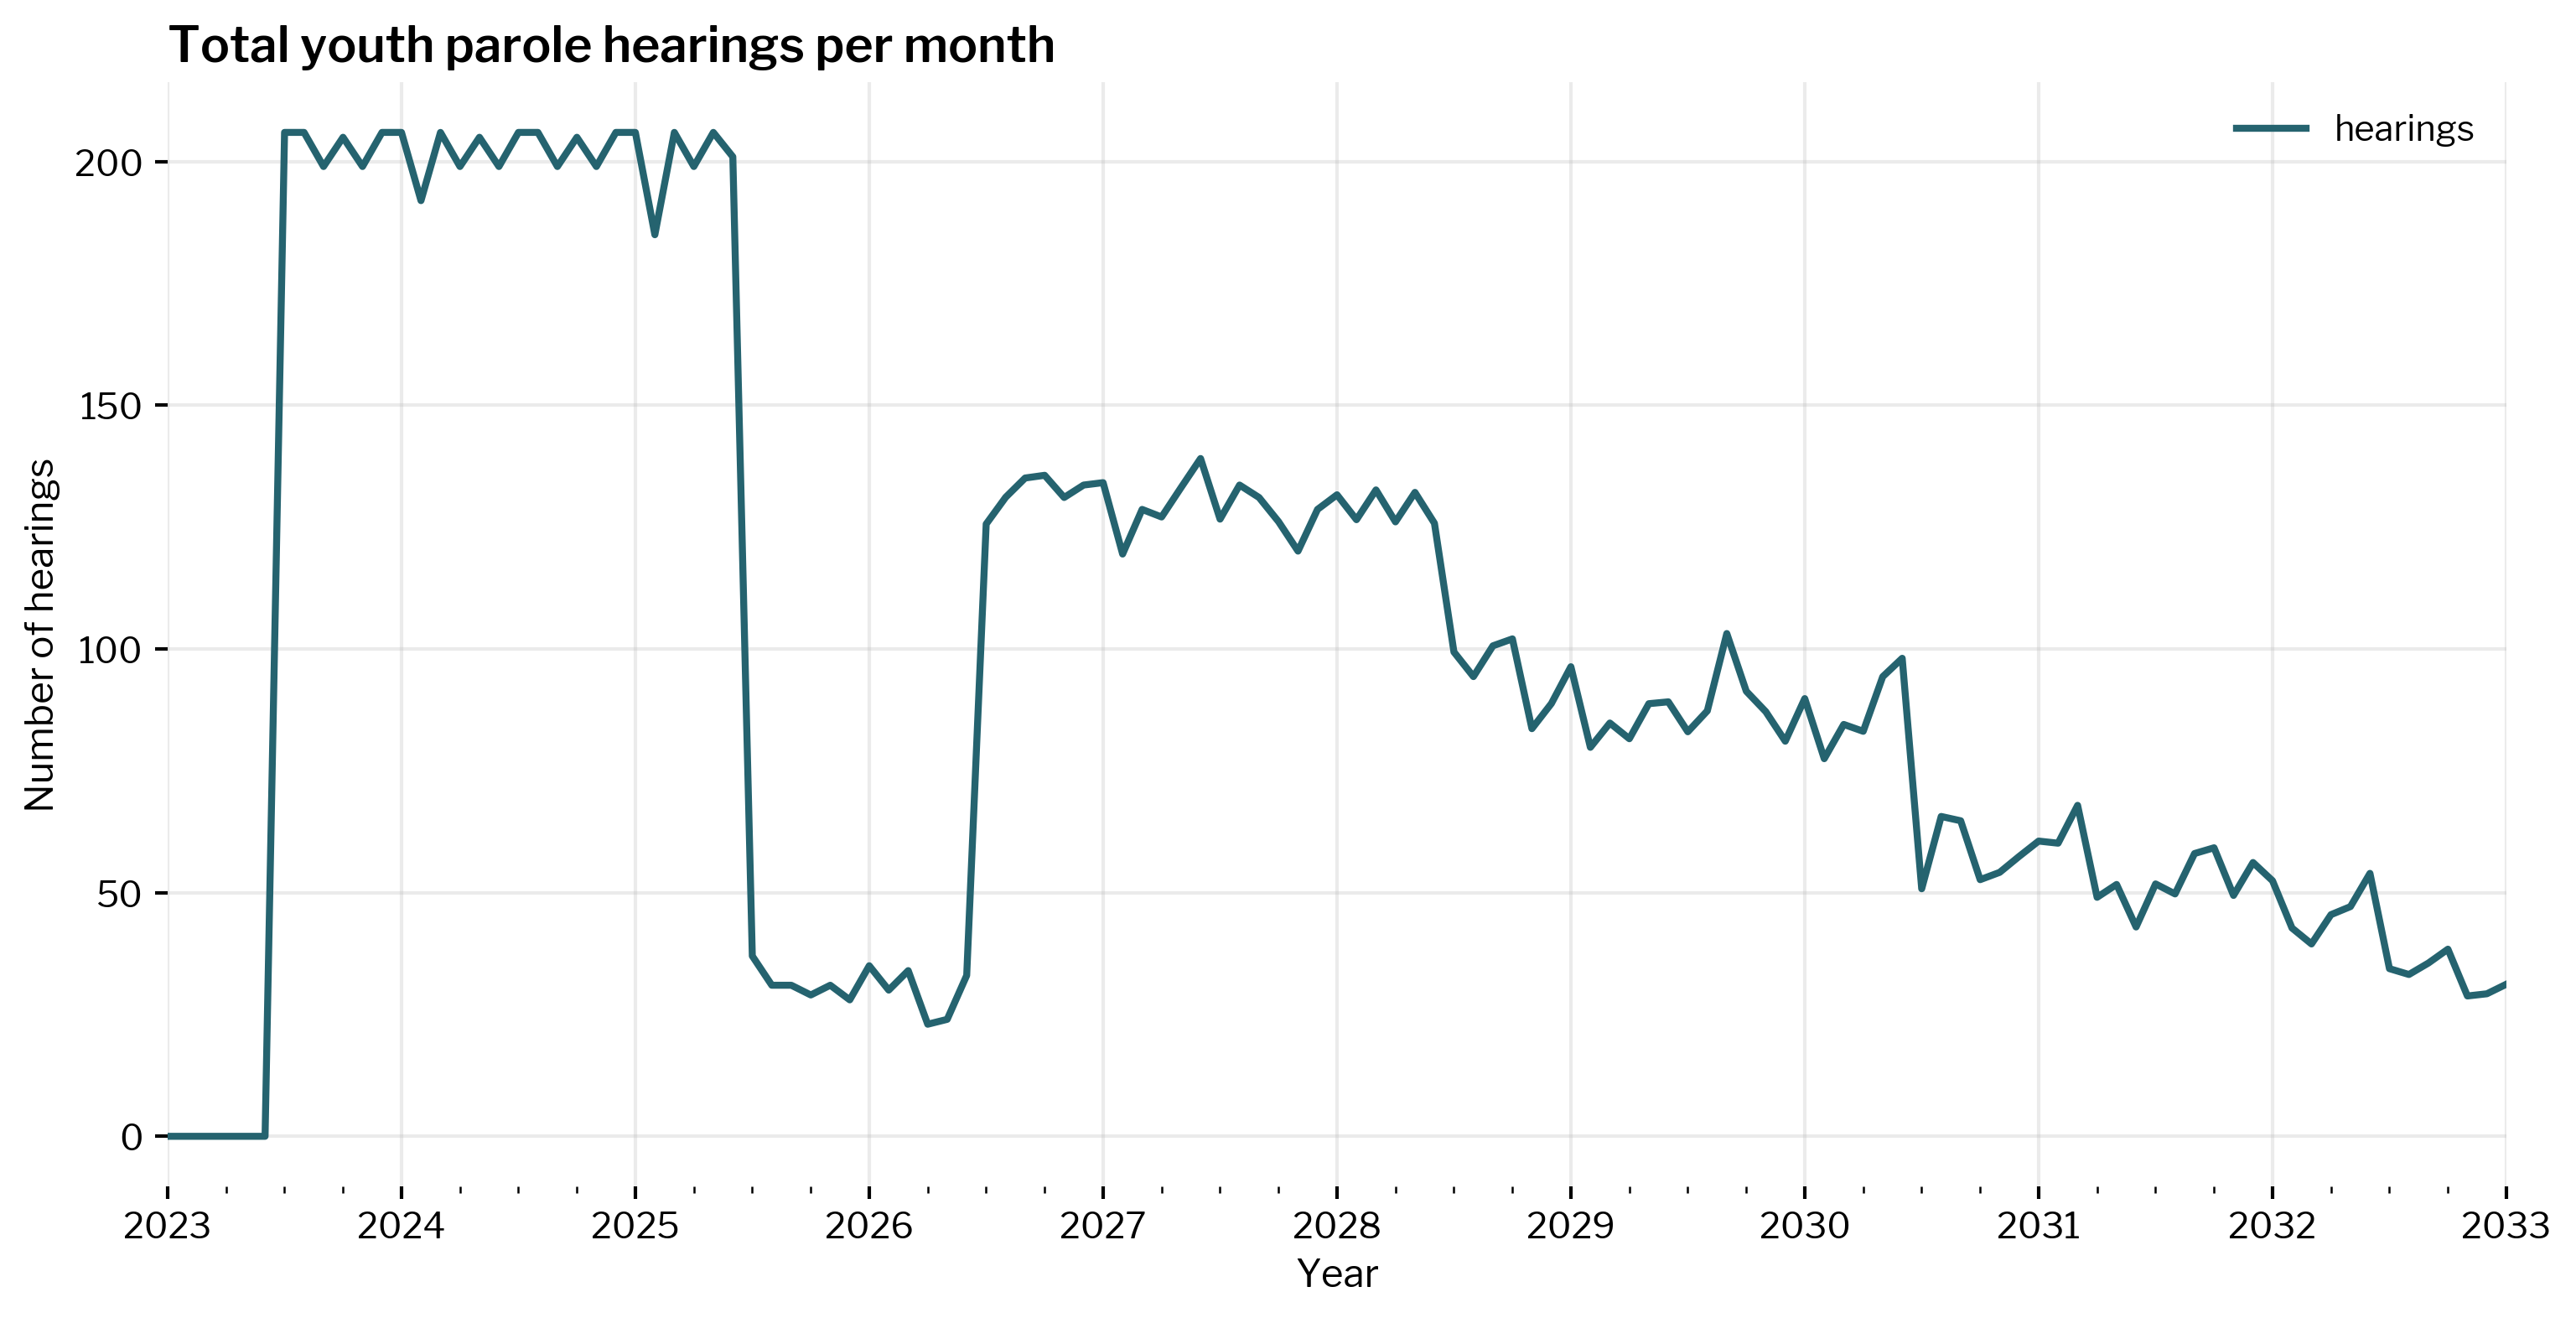

In [60]:
cas.groupby([cas["hearing_date_policy"].dt.to_period("M").dt.to_timestamp()])[
    ["remaining_hearing_proportion"]
].sum().reindex(
    pd.date_range(start="2023-01-01", end=cas.release_month_policy.max(), freq="MS"),
    level=0,
).fillna(
    0
    # ).reset_index().pivot(
    #     index="release_month_policy",
    #     columns="hearing_label"
).rename(
    columns={"remaining_hearing_proportion": "hearings"}
).loc[
    :"2033-01-01"
].plot()
plt.title("Total youth parole hearings per month")
plt.xlabel("Year")
plt.ylabel("Number of hearings")
plt.gca().set_aspect(0.25);

In [61]:
cas.groupby([cas["hearing_date_policy"].dt.to_period("M").dt.to_timestamp()])[
    ["remaining_hearing_proportion"]
].sum().reindex(
    pd.date_range(start="2023-01-01", end=cas.release_month_policy.max(), freq="MS"),
    level=0,
).fillna(
    0
    # ).reset_index().pivot(
    #     index="release_month_policy",
    #     columns="hearing_label"
).rename(
    columns={"remaining_hearing_proportion": "hearings"}
).loc[
    "2023-07-01":"2025-06-01"
].mean()

hearings    202.166667
dtype: float64

# OTHER

#### extreme case: 52 where control hearing is before policy hearing, small effect

In [62]:
delayed = cas[cas.release_date_control < cas.release_date_policy].drop_duplicates(
    subset="ID"
)

In [63]:
delayed.subset.value_counts()

immediately_eligible         46
eligible_within_two_years     6
Name: subset, dtype: int64

In [64]:
delayed.release_delta.describe()

count                               52
mean     -171 days +22:17:42.636310486
std        141 days 08:17:41.729152354
min      -532 days +09:23:04.704237720
25%      -263 days +01:49:09.834056952
50%      -132 days +15:46:37.523598844
75%       -59 days +19:09:19.801456043
max        -2 days +03:40:35.401693769
Name: release_delta, dtype: object

<AxesSubplot: xlabel='release_month_control'>

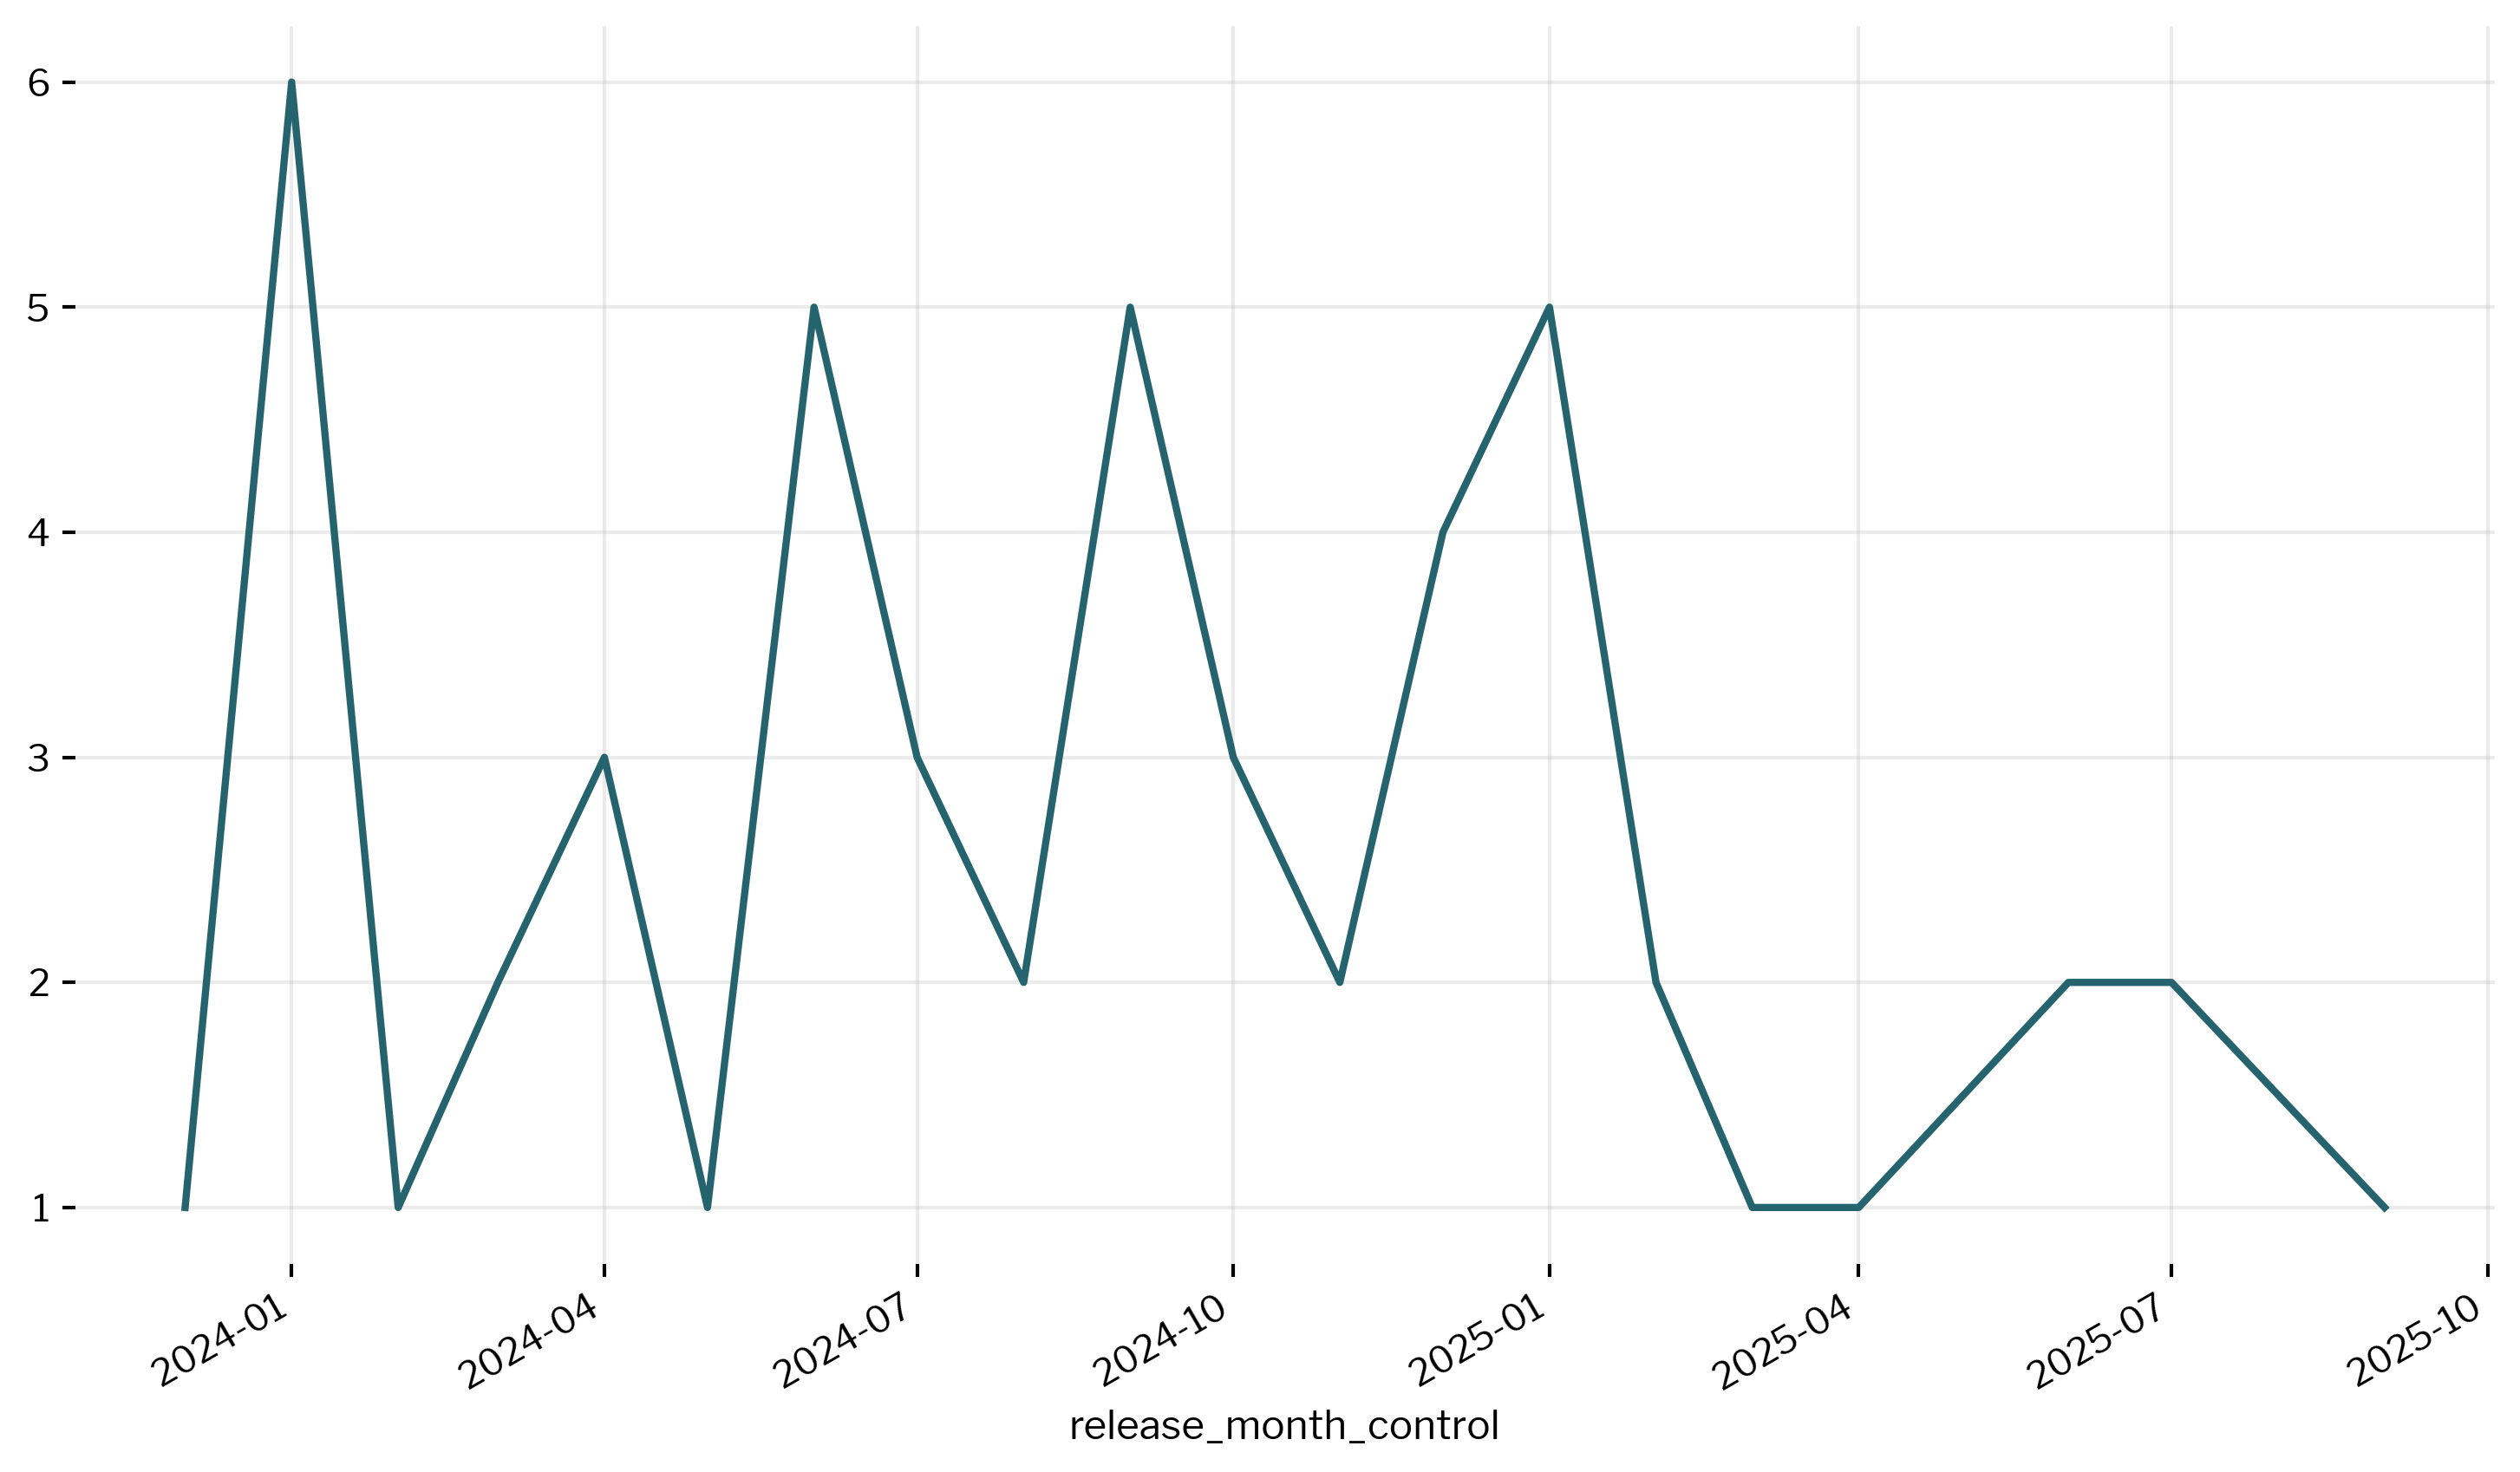

In [65]:
delayed.groupby("release_month_control").ID.count().plot()

In [66]:
cas[cas.release_delta < pd.Timedelta(1, "S")].drop_duplicates(subset="ID").sort_values(
    by="release_date_policy"
)

,ID,SenType,Minimum,Maximum,ReleaseType,Offense Group,Race,Ethnicity,Gender,Age,Offense Age,Time Served (Months),Revocation (Y/N),Housing Program,Disability Placement Program,Time Period,time_served_months,time_served_years,start_date_calc,start_year,minimum_sentence_years,parole_eligibility_years,parole_eligibility_date_control,parole_eligibility_date_policy,immediately_eligible,eligible_within_two_years,subset,two_year_hearing_spread,parole_eligibility_date_policy_adjusted,hearing_label,percent_outflow,time_offset,remaining_hearing_proportion,hearing_date_control,hearing_date_policy,release_date_control,release_date_policy,release_month_control,release_month_policy,release_delta
13806,642072,Life with Parole,24Y 0M,Life w/ Parole,MEPD,Murder 2nd,White,White,Male,41,23,218.7,No,Sensitive Needs Yard,NaN,1990-01-01 - 9999-12-31,218.7,18.225000,2004-08-13 20:49:30.144000000,2004,24.000000,20.000000,2023-08-14 14:49:30.144000000,2018-08-14 08:49:30.144000000,True,True,immediately_eligible,2024-03-09 15:28:53.883615356,2024-03-09 15:28:53.883615356,1st Hearing,0.17,0 days,1.0,2023-08-14 14:49:30.144000000,2024-03-09 15:28:53.883615356,2024-01-11 14:49:30.144000000,2024-08-06 15:28:53.883615356,2024-01-01,2024-08-01,-209 days +23:20:36.260384644
330,100013,Life with Parole,24Y 0M,Life w/ Parole,MEPD,Other Assault/Battery,Black,Black,Female,38,20,218.5,No,General Population,DNM,1988-01-01 - 9999-12-31,218.5,18.208333,2004-08-19 22:49:30.720000000,2004,24.000000,20.000000,2023-08-20 16:49:30.720000000,2018-08-20 10:49:30.720000000,True,True,immediately_eligible,2024-03-11 00:02:31.547668180,2024-03-11 00:02:31.547668180,1st Hearing,0.17,0 days,1.0,2023-08-20 16:49:30.720000000,2024-03-11 00:02:31.547668180,2024-01-17 16:49:30.720000000,2024-08-08 00:02:31.547668180,2024-01-01,2024-08-01,-204 days +16:46:59.172331820
13542,639039,Life with Parole,22Y 0M,Life w/ Parole,MEPD,Murder 2nd,Mexican,Mexican,Male,41,22,218.1,No,General Population,NaN,1990-01-01 - 9999-12-31,218.1,18.175000,2004-09-01 02:49:31.872000000,2004,22.000000,20.000000,2023-09-01 20:49:31.872000000,2018-09-01 14:49:31.872000000,True,True,immediately_eligible,2024-03-12 12:13:13.396615768,2024-03-12 12:13:13.396615768,1st Hearing,0.17,0 days,1.0,2023-09-01 20:49:31.872000000,2024-03-12 12:13:13.396615768,2024-01-29 20:49:31.872000000,2024-08-09 12:13:13.396615768,2024-01-01,2024-08-01,-193 days +08:36:18.475384232
20016,713346,Life with Parole,20Y 0M,Life w/ Parole,MEPD,Murder 2nd,Black,Black,Male,34,16,215.7,No,General Population,NaN,1990-01-01 - 9999-12-31,215.7,17.975000,2004-11-13 02:49:38.784000000,2004,20.000000,20.000000,2023-11-13 20:49:38.784000000,2018-11-13 14:49:38.784000000,True,True,immediately_eligible,2024-03-24 02:47:35.633512176,2024-03-24 02:47:35.633512176,1st Hearing,0.17,0 days,1.0,2023-11-13 20:49:38.784000000,2024-03-24 02:47:35.633512176,2024-04-11 20:49:38.784000000,2024-08-21 02:47:35.633512176,2024-04-01,2024-08-01,-132 days +18:02:03.150487824
9198,425515,Life with Parole,20Y 0M,Life w/ Parole,MEPD,Murder 2nd,White,White,Male,37,19,215.4,No,Enhanced Out Patient,NaN,1990-01-01 - 9999-12-31,215.4,17.950000,2004-11-22 05:49:39.648000000,2004,20.000000,20.000000,2023-11-22 23:49:39.648000000,2018-11-22 17:49:39.648000000,True,True,immediately_eligible,2024-03-26 01:49:30.037144036,2024-03-26 01:49:30.037144036,1st Hearing,0.17,0 days,1.0,2023-11-22 23:49:39.648000000,2024-03-26 01:49:30.037144036,2024-04-20 23:49:39.648000000,2024-08-23 01:49:30.037144036,2024-04-01,2024-08-01,-125 days +22:00:09.610855964
14646,652622,Life with Parole,21Y 4M,Life w/ Parole,MEPD,Murder 2nd,Mexican,Mexican,Male,36,18,215.1,No,General Population,NaN,1990-01-01 - 9999-12-31,215.1,17.925000,2004-12-01 08:49:40.512000000,2004,21.333333,20.000000,2023-12-02 02:49:40.512000000,2018-12-01 20:49:40.512000000,True,True,immediately_eligible,2024-03-27 03:08:59.331407348,2024-03-27 03:08:59.331407348,1st Hearing,0.17,0 days,1.0,2023-12-02 02:49:40.512000000,2024-03-27 03:08

<AxesSubplot: xlabel='release_month_policy'>

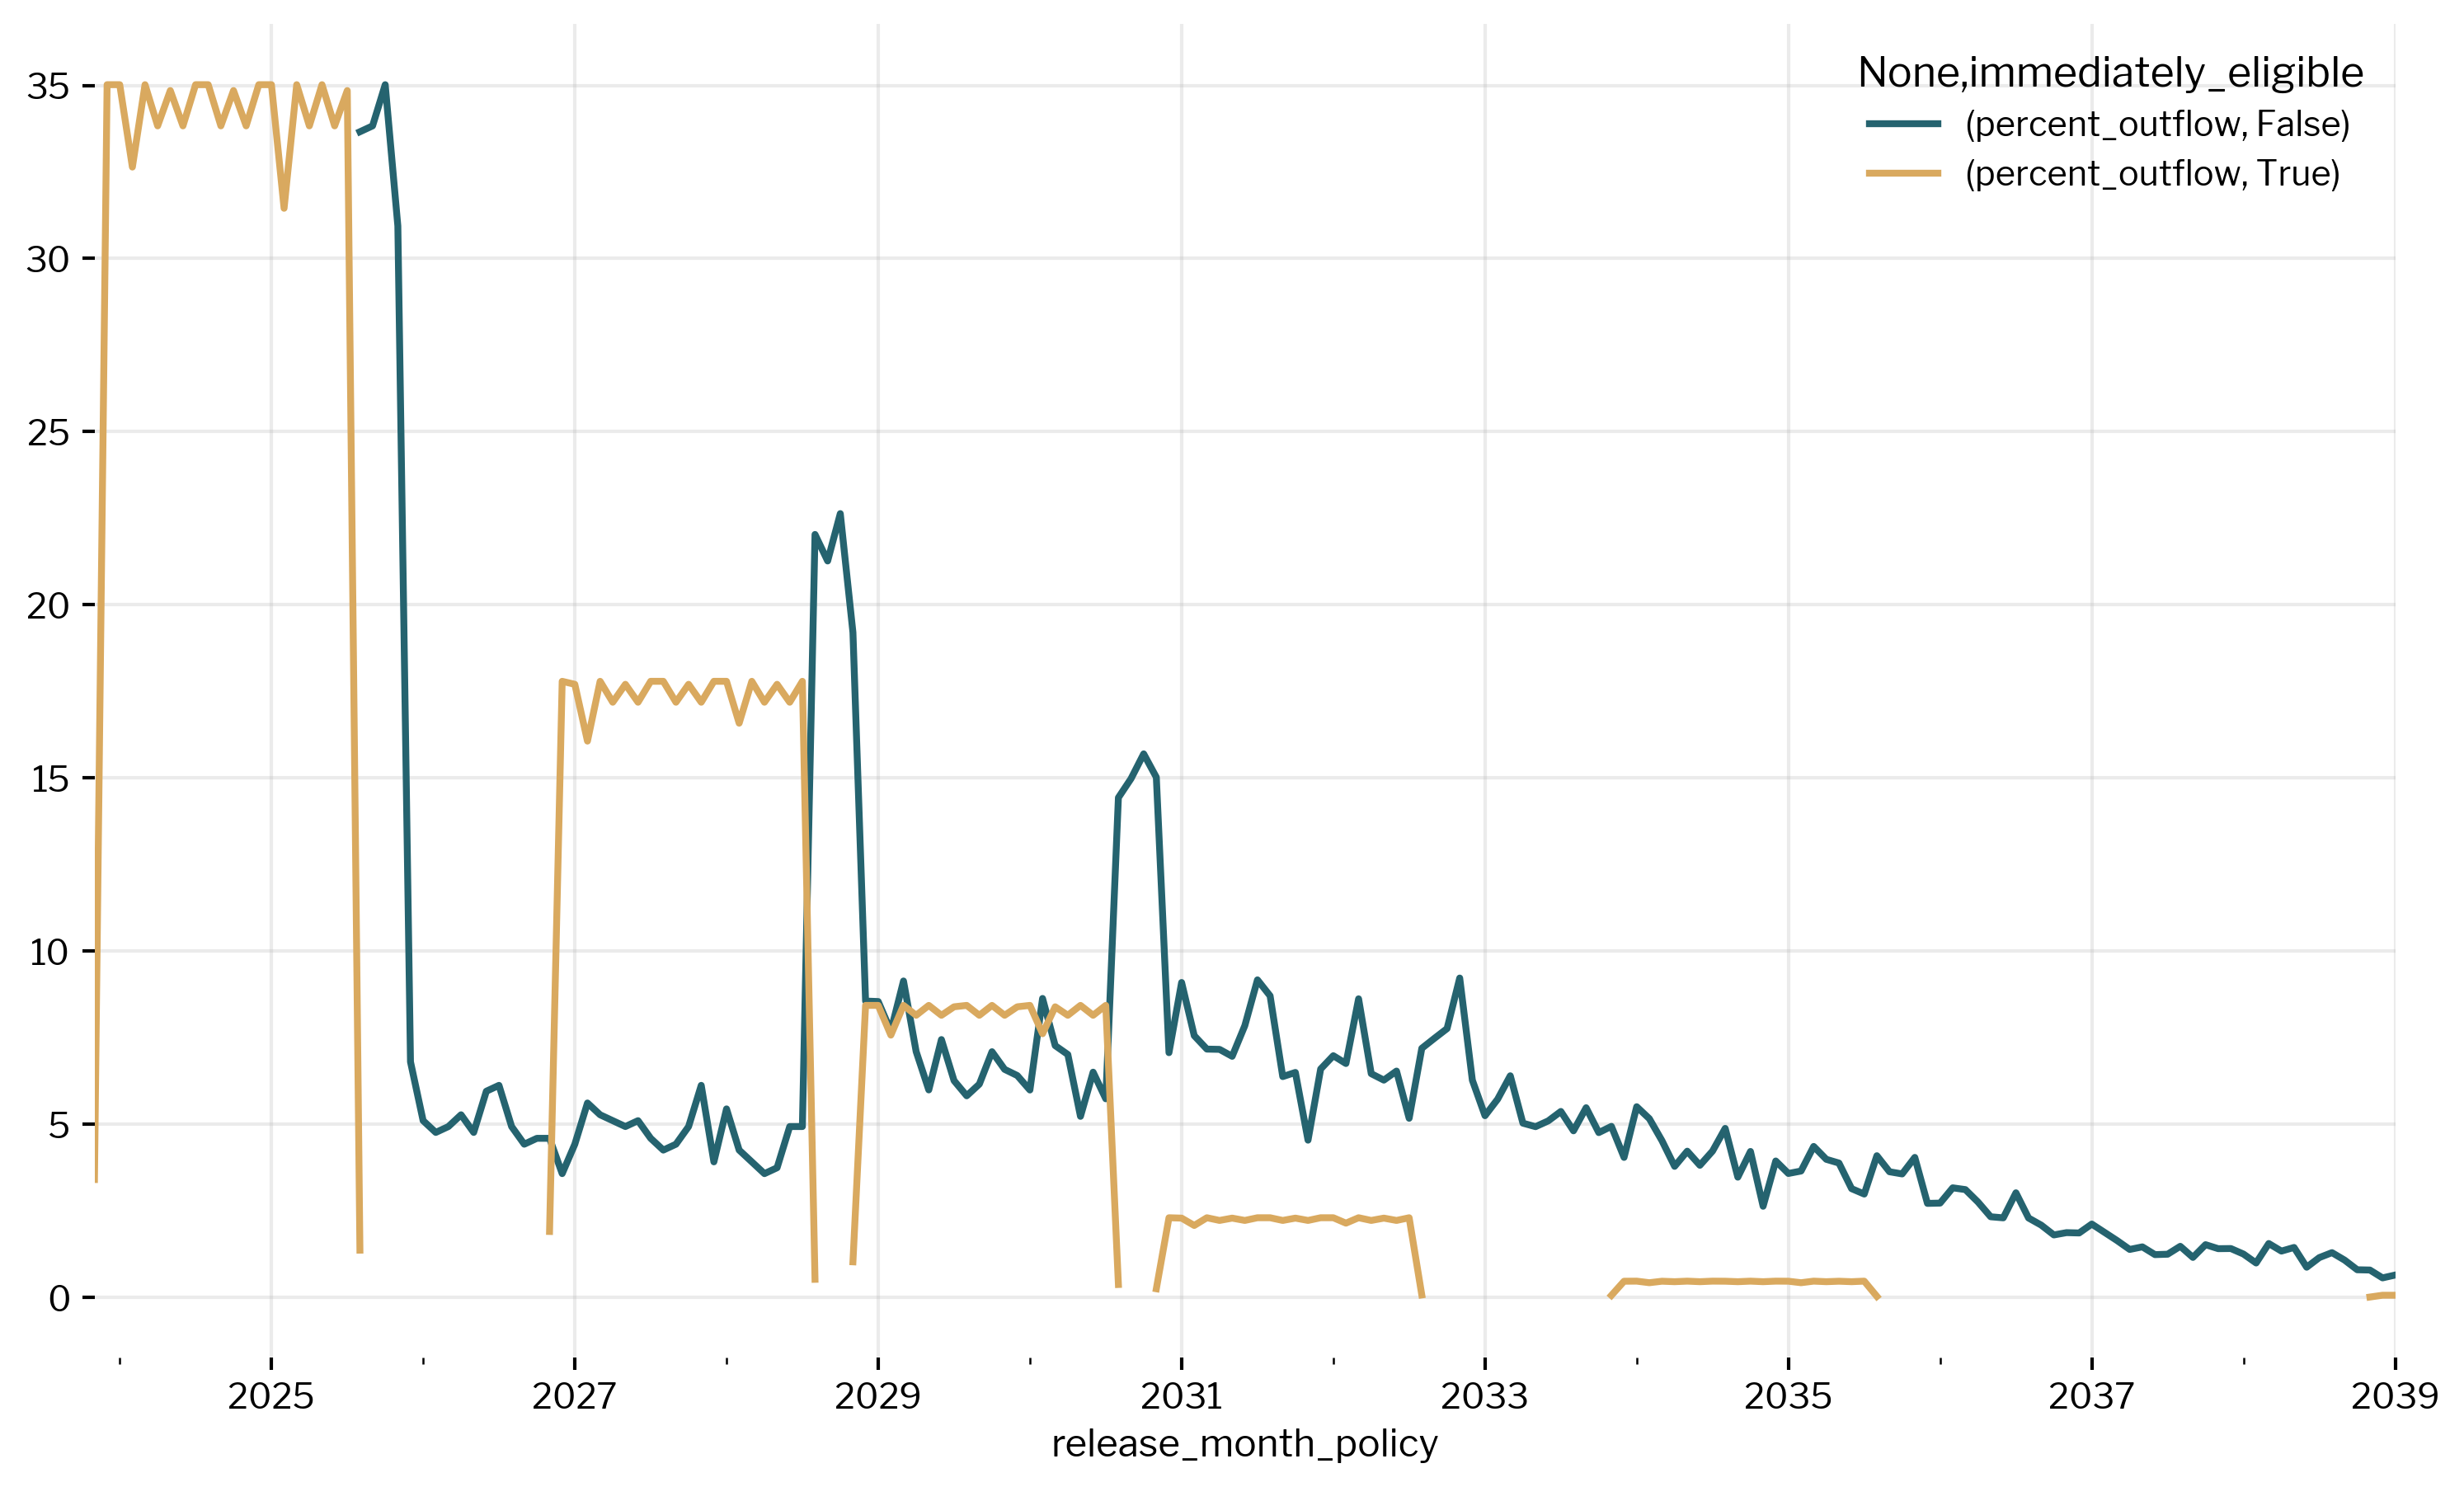

In [67]:
cas.groupby(["release_month_policy", "immediately_eligible"])[
    ["percent_outflow"]
].sum().reindex(
    pd.date_range(start="2023-01-01", end=cas.release_month_policy.max(), freq="MS"),
    level=0,
).fillna(
    0
).reset_index().pivot(
    index="release_month_policy", columns="immediately_eligible"
).loc[
    :"2039-01-01"
].plot()

In [68]:
grouped = (
    cas.groupby(["hearing_month_control", "immediately_eligible"])[["percent_outflow"]]
    .sum()
    .reindex(
        pd.date_range(
            start="2023-01-01", end=cas.hearing_month_control.max(), freq="MS"
        ),
        level=0,
    )
    .fillna(0)
    .reset_index()
    .pivot(index="hearing_month_control", columns="immediately_eligible")
    .loc[:"2039-01-01"]
    .plot()
)

KeyError: 'hearing_month_control'

In [ ]:
cas[(cas.immediately_eligible) & (cas.hearing_number == 1)].groupby(
    "hearing_month_control"
).ID.count().plot()

In [ ]:
cas[(cas.immediately_eligible) & (cas.hearing_number == 1)].drop_duplicates(
    subset="ID"
).groupby("hearing_month_policy")[["ID"]].count().plot()

In [ ]:
# cas = cas[~cas.immediately_eligible]

In [ ]:
results.index = [
    pd.to_datetime(date, format="%Y-%m-%d").date() for date in results.index
]

In [ ]:
ax = results.loc[pd.date_range(start="2023-01-01", end="2028-01-01", freq="YS")][
    ["control", "policy"]
].plot.bar()
# ax.xaxis.set_major_locator(mdates.YearLocator(interval=1))
# ax.xaxis.set_major_formatter('{x} km')
ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))